# Priority 1

###  Problem 1 - How to measure the viability of Level 2 and DC fast charging sites in 5 years (after grant funding, which sites will be worth investing in to keep running) 
### Approach – Individual EV and general utilizations will be the most important metric to consider.
Prior Projects – We have done a similar study mostly focused on demand forecast using EV charging data from CARTA* from various points of view:
Number of charging events
Number of unique EVs
Energy demands


# ---------------------------------------------------------------------------------------------------------

#  Priority 2

###  Problem 2 - What is the optimal power per port ratio in Urban vs Rural vs Interstate locations? When does adding more power to a site have diminishing returns?
### Approach – Identifying both obvious and hidden demands for different power rates. Run optimization to define the best ratios. 
Obvious demand is the actual demand that has been recorded in data
Hidden demand or demand not met is the one that has not been met because the EV user has not been able to find a charging dtation
Metrics – Location, utilization of charging stations, average parking and charging times, number of events, types of cars visiting.
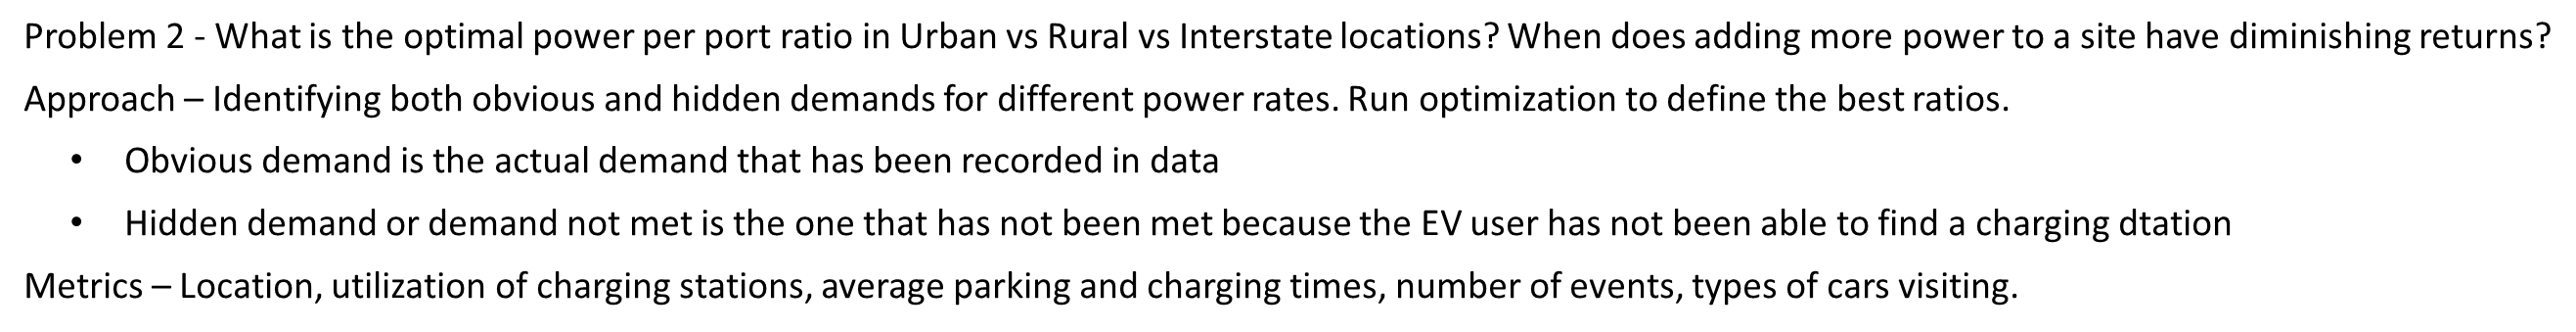

# ---------------------------------------------------------------------------------------------------------

# Priority 3

### Problem 4 - Tools for measuring/reporting location based GHG savings based on Valley generation mix (not national averages)
### Approach – Crossing charging event data with the generation mix data and studying the GHG saving. 
Using power flow analysis approaches, we will define the marginal impacts of each charging station and study the GHG impact.
Prior projects – Multiple power flow analysis and optimization projects. GHG impact studies using CARTA data.
Studied the impact of optimal scheduling on different operation parameters including GHG emmissions


# ---------------------------------------------------------------------------------------------------------

# Libraries 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone


# Read File

In [17]:
df = pd.read_csv('Session-Details-Summary-20240119-3.csv') 


## Convert Start and End Date to EST Time Zone

In [18]:
unique_values_time_zone = df['Start Time Zone'].unique()
print(unique_values_time_zone)

['EST' 'CST' 'PST' 'CDT' 'EDT' 'PDT']


In [19]:
# Convert Start and End Date to datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

def convert_to_est(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


# Apply function to Start and End Date
df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

In [20]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
print(f"Number of missing values in 'Port Type': {missing_count}")

#df['Port Type'] = df['Port Type'].fillna('Missing')

Number of missing values in 'Port Type': 0


### Count the number of port type

In [21]:
unique_values_port_type = df['Port Type'].unique()

# Count occurrences of each unique value
port_type_counts = df['Port Type'].value_counts()

# Print unique values
print("Unique Values:", unique_values_port_type)

# Print counts of each unique value
print("Number of charging events")
print(port_type_counts)


Unique Values: ['Level 2' 'DC Fast' nan]
Number of charging events
Port Type
Level 2    21490
DC Fast    15453
Name: count, dtype: int64


### Count the number of unique MAC addresses for each charging station

In [22]:
unique_values_MAC_address=df["MAC Address"].unique()
MAC_Address_counts=df["MAC Address"].value_counts()
print(unique_values_MAC_address)

print(MAC_Address_counts)

['0024:B100:0003:D7DA' '0024:B100:0001:1599' '0024:B100:0008:0B14'
 '0024:B100:0008:0AE7' '0024:B100:0008:1375' '0024:B100:0008:0B20'
 '0024:B100:0003:775A' '0024:B100:0008:106D' '0024:B100:0008:0FFB'
 '0024:B100:0003:F0BC' '0024:B100:0008:14C0' '0024:B100:0006:BE10'
 '0024:B100:0006:D44C' '0024:B100:0004:721A' '0024:B100:0004:8409'
 '0024:B100:0008:163D' '0024:B100:0003:7A2B' '0024:B100:0001:1EE1'
 '0024:B100:0008:0CA7' '0024:B100:000B:CB0D' '0024:B100:0004:1E0B'
 '0024:B100:0008:00F2' '0024:B100:0004:EFCC' '0024:B100:0008:1355'
 '0024:B100:0001:19F5' '0024:B100:0008:04A6' '0024:B100:0008:0C5B'
 '0024:B100:0008:116E' '0024:B100:0008:0440' '0024:B100:0001:1978'
 '0024:B100:0008:156C' '0024:B100:000B:93E7' '0024:B100:0004:697C'
 '0024:B100:0008:135A' '0024:B100:0008:1FA0' '0024:B100:0001:1A52'
 '0024:B100:0008:1E31' '0024:B100:0004:1C53' '0024:B100:0001:1EA0'
 '0024:B100:0008:1011' '0024:B100:000C:EC0A' '0024:B100:0008:166B'
 '0024:B100:0006:D26A' '0024:B100:0008:0BA4' '0024:B100:0004:3

In [23]:
# Count the number of unique MAC addresses for each charging station
mac_counts = df.groupby('Station Name')['MAC Address'].nunique()

# Sort in descending order
sorted_mac_counts = mac_counts.sort_values(ascending=False)

# Display the top 30
top_30 = sorted_mac_counts.head(30)

# Print the result
print(top_30)

Station Name
7SPC / STARKVILLE DWTN               3
CLW / MAIN ST                        3
PES / LEFT STATION                   3
STARKVILLE UTIL / STARKVILLE DWTN    2
7SPC / TRI-COUNTY EMC                2
7SPC / TVPPA OFFICE                  2
PES / RIGHT STATION                  2
7SPC / GUNTERSVILLE PD               2
BRIGHTRIDGE EV / BR-JC LIBRARY       2
HOLSTONELECTRIC / STATION 1          2
HARTSELLE 1 / HARTSELLE 1            2
STARKVILLE UTIL / STARKVILLE REC     1
SES-TN / STATION 2                   1
PEPA / STATION 1                     1
SCOTTSBORO EPB / SEPB DCFC (R)       1
SCOTTSBORO EPB / SEPB DCFC (L)       1
SCOTTSBORO EPB / MAIN OFFICE         1
STEMC / STATION 1 (L)                1
STEMC / STATION 2 (R)                1
TRNG CENTER / TRAININGCENTER1        1
PEPA / STATION 2                     1
SES-TN / STATION 1                   1
7SPC / BR - JC LIBRARY               1
PARIS BPU / STATION 2(R)             1
LAWRENCEBURG / STATION 1             1
HOLSTONELECT

In [24]:
missing_values = df.isnull().sum()

print(missing_values)

Station Name                           0
MAC Address                            0
Org Name                               0
Start Date                             0
Start Time Zone                        0
End Date                               7
End Time Zone                          0
Transaction Date (Pacific Time)       59
Total Duration (hh:mm:ss)              0
Charging Time (hh:mm:ss)               0
Energy (kWh)                           0
GHG Savings (kg)                       0
Gasoline Savings (gallons)             0
Port Type                           1681
Port Number                            0
Plug Type                           1681
EVSE ID                                0
Address 1                              0
Address 2                          36130
City                                   0
State/Province                         0
Zip/Postal Code                        0
Country                                0
Latitude                               0
Longitude       

In [25]:
missing_count_NaN = df.isna().sum()
print(missing_count_NaN)

Station Name                           0
MAC Address                            0
Org Name                               0
Start Date                             0
Start Time Zone                        0
End Date                               7
End Time Zone                          0
Transaction Date (Pacific Time)       59
Total Duration (hh:mm:ss)              0
Charging Time (hh:mm:ss)               0
Energy (kWh)                           0
GHG Savings (kg)                       0
Gasoline Savings (gallons)             0
Port Type                           1681
Port Number                            0
Plug Type                           1681
EVSE ID                                0
Address 1                              0
Address 2                          36130
City                                   0
State/Province                         0
Zip/Postal Code                        0
Country                                0
Latitude                               0
Longitude       

In [26]:
df=df.dropna(subset=["Port Type"])

# Which state?

In [29]:
df["State/Province"].value_counts()

State/Province
Tennessee      19372
Alabama        10803
Mississippi     4146
Kentucky        1931
Georgia          691
Name: count, dtype: int64

In [30]:
# Sample mapping dictionary
state_mapping = {
    'Tennessee': 'TN',
    'Alabama': 'AL',
    'Mississippi': 'MS',
    'Kentucky': 'KY',
    'Georgia': 'GA',
    
}

# Create a new column with state codes
df['State Code'] = df['State/Province'].map(state_mapping)

# Assuming state_counts is calculated using df["State Code"].value_counts()
state_counts = df["State Code"].value_counts()

# Create a choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=state_counts.index,
    z=state_counts.values.astype(float),
    locationmode="USA-states",
    colorscale="turbo",
))

# Update layout
fig.update_layout(
    title_text="Number of Occurrences by State",
    geo_scope="usa",
)

# Show the map in the default renderer (browser)
fig.show()




# Separate df with Level2 (L2) and Fast charging (DC)

In [70]:
df_L2 = df[(df['Port Type'].str.fullmatch('Level 2'))]

df_DC = df[(df['Port Type'].str.fullmatch('DC Fast'))]

In [71]:
df_L2

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,OnRamp ID Tag,Payment Terminal Session ID,Vehicle MAC ID,Start_Time_EST,End_Time_EST,State Code,Start_Tim_EST,Hour,Year,Month
38564,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-10-31 16:02:22,EDT,2018-10-31 16:02:39,EDT,2018-10-31 13:02:41,00:00:17,00:00:00,...,NaN,NaN,NaN,2018-10-31 15:02:22-05:00,2018-10-31 15:02:39-05:00,TN,2018-10-31 15:02:22-05:00,15.0,2018.0,10.0
38563,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-10-31 16:04:34,EDT,2018-10-31 16:04:38,EDT,2018-10-31 13:04:38,00:00:04,00:00:00,...,NaN,NaN,NaN,2018-10-31 15:04:34-05:00,2018-10-31 15:04:38-05:00,TN,2018-10-31 15:04:34-05:00,15.0,2018.0,10.0
38562,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-05 08:54:12,EST,2018-11-05 08:54:29,EST,2018-11-05 05:54:32,00:00:17,00:00:00,...,NaN,NaN,NaN,2018-11-05 08:54:12-05:00,2018-11-05 08:54:29-05:00,TN,2018-11-05 08:54:12-05:00,8.0,2018.0,11.0
38561,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-06 09:49:44,EST,2018-11-06 12:42:42,EST,2018-11-06 09:42:43,02:53:01,02:52:48,...,NaN,NaN,NaN,2018-11-06 09:49:44-05:00,2018-11-06 12:42:42-05:00,TN,2018-11-06 09:49:44-05:00,9.0,2018.0,11.0
38560,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-06 13:00:11,EST,2018-11-06 14:55:52,EST,2018-11-06 11:55:53,01:55:44,01:55:34,...,NaN,NaN,NaN,2018-11-06 13:00:11-05:00,2018-11-06 14:55:52-05:00,TN,2018-11-06 13:00:11-05:00,13.0,2018.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,7SPC / TVPPA OFFICE,0024:B100:0003:D7DA,Seven States Power Corporation,2024-01-19 08:09:24,EST,2024-01-19 13:50:19,EST,2024-01-19 10:54:34,05:40:55,05:13:55,...,NaN,NaN,NaN,2024-01-19 08:09:24-05:00,2024-01-19 13:50:19-05:00,TN,2024-01-19 08:09:24-05:00,8.0,2024.0,1.0
14,CULLMANELECTRIC / CEC MAIN OFFICE,0024:B100:0003:F0BC,Cullman Electric Cooperative,2024-01-19 10:18:23,CST,2024-01-19 10:47:03,CST,2024-01-19 08:47:51,00:28:40,00:28:21,...,NaN,NaN,NaN,2024-01-19 11:18:23-05:00,2024-01-19 11:47:03-05:00,AL,2024-01-19 11:18:23-05:00,11.0,2024.0,1.0
38566,CLW / MAIN ST,0024:B100:000B:CB0D,Columbus Light & Water,2024-01-19 12:19:23,CST,NaT,CST,NaN,00:35:19,00:34:49,...,NaN,NaN,NaN,2024-01-19 13:19:23-05:00,NaT,MS,2024-01-19 13:19:23-05:00,13.0,2024.0,1.0
38614,7SPC / NASA USSRC L,0024:B100:0004:595E,Seven States Power Corporation,2024-01-19 12:40:27,CST,NaT,CST,NaN,00:15:16,00:14:51,...,NaN,NaN,NaN,2024-01-19 13:40:27-05:00,NaT,AL,2024-01-19 13:40:27-05:00,13.0,2024.0,1.0


Level 2: 21490
DC Fast: 15453


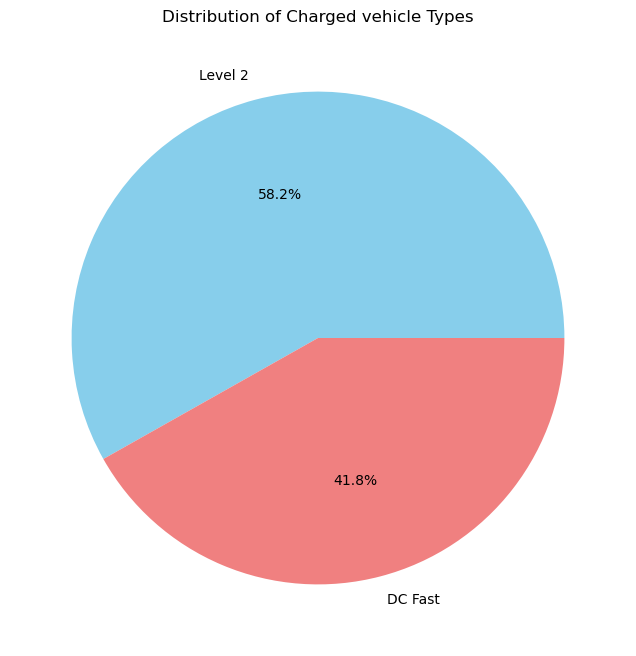

In [72]:
# Count the number of Level 2 and DC Fast charging stations
count_by_port_type = df['Port Type'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
count_by_port_type.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Charged vehicle Types')
plt.ylabel('')  # Remove the default ylabel

# Print the count of Level 2 and DC Fast charging stations
for port_type, count in count_by_port_type.items():
    print(f"{port_type}: {count}")

plt.show()

In [73]:
df_L2.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Zip/Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency',
       'Fee', 'Ended By', 'Plug In Event ID', 'Transaction ID',
       'Driver Zip/Postal Code', 'User ID', 'Start SOC', 'End SOC', 'County',
       'System S/N', 'Model Number', 'OnRamp ID Tag',
       'Payment Terminal Session ID', 'Vehicle MAC ID', 'Start_Time_EST',
       'End_Time_EST', 'State Code', 'Start_Tim_EST', 'Hour', 'Year', 'Month'],
      dtype='object')

In [74]:
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2].split()[0])  # Extract seconds and ignore 'AM' or 'PM'
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0  # Handle other cases if needed

# Assuming 'Total Duration' is in string format '1:26:32 AM'
df_L2['Total Duration'] = df_L2['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
df_DC['Total Duration'] = df_DC['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds) 


C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3339881360.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3339881360.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
df

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),...,OnRamp ID Tag,Payment Terminal Session ID,Vehicle MAC ID,Start_Time_EST,End_Time_EST,State Code,Start_Tim_EST,Hour,Year,Month
38564,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-10-31 16:02:22,EDT,2018-10-31 16:02:39,EDT,2018-10-31 13:02:41,00:00:17,00:00:00,...,NaN,NaN,NaN,2018-10-31 15:02:22-05:00,2018-10-31 15:02:39-05:00,TN,2018-10-31 15:02:22-05:00,15.0,2018.0,10.0
38563,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-10-31 16:04:34,EDT,2018-10-31 16:04:38,EDT,2018-10-31 13:04:38,00:00:04,00:00:00,...,NaN,NaN,NaN,2018-10-31 15:04:34-05:00,2018-10-31 15:04:38-05:00,TN,2018-10-31 15:04:34-05:00,15.0,2018.0,10.0
38562,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-05 08:54:12,EST,2018-11-05 08:54:29,EST,2018-11-05 05:54:32,00:00:17,00:00:00,...,NaN,NaN,NaN,2018-11-05 08:54:12-05:00,2018-11-05 08:54:29-05:00,TN,2018-11-05 08:54:12-05:00,8.0,2018.0,11.0
38561,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-06 09:49:44,EST,2018-11-06 12:42:42,EST,2018-11-06 09:42:43,02:53:01,02:52:48,...,NaN,NaN,NaN,2018-11-06 09:49:44-05:00,2018-11-06 12:42:42-05:00,TN,2018-11-06 09:49:44-05:00,9.0,2018.0,11.0
38560,TVPPA 7SPC / CORP OFFICE,0024:B100:0002:E5FB,TVPPA & 7SPC,2018-11-06 13:00:11,EST,2018-11-06 14:55:52,EST,2018-11-06 11:55:53,01:55:44,01:55:34,...,NaN,NaN,NaN,2018-11-06 13:00:11-05:00,2018-11-06 14:55:52-05:00,TN,2018-11-06 13:00:11-05:00,13.0,2018.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38614,7SPC / NASA USSRC L,0024:B100:0004:595E,Seven States Power Corporation,2024-01-19 12:40:27,CST,NaT,CST,NaN,00:15:16,00:14:51,...,NaN,NaN,NaN,2024-01-19 13:40:27-05:00,NaT,AL,2024-01-19 13:40:27-05:00,13.0,2024.0,1.0
38599,JEFFERSON AVE. / OXFORD STA1(L),0024:B100:0001:1FF5,Oxford Utilities,2024-01-19 12:48:52,CST,NaT,CST,NaN,00:08:30,00:08:20,...,NaN,NaN,00182338e789,2024-01-19 13:48:52-05:00,NaT,MS,2024-01-19 13:48:52-05:00,13.0,2024.0,1.0
5391,CULLMANELECTRIC / CEC MAIN OFFICE,0024:B100:0003:F0BC,Cullman Electric Cooperative,2023-11-05 01:35:11,CST,2023-11-05 02:24:51,CST,2023-11-05 01:25:30,00:49:42,00:49:07,...,NaN,NaN,NaN,NaT,2023-11-05 03:24:51-05:00,AL,NaT,NaN,NaN,NaN
5392,CULLMANELECTRIC / STATION1-L,0024:B100:0001:172A,Cullman Electric Cooperative,2023-11-05 01:19:41,CST,2023-11-05 01:21:45,CST,2023-11-05 00:21:47,00:02:03,00:00:00,...,NaN,NaN,NaN,NaT,NaT,AL,NaT,NaN,NaN,NaN


In [76]:
# For DC fast charging sites
df_DC['Total Duration'] = pd.to_numeric(df_DC['Total Duration'], errors='coerce')
df_DC['Energy (kWh)'] = pd.to_numeric(df_DC['Energy (kWh)'], errors='coerce')
df_DC['Fee'] = pd.to_numeric(df_DC['Fee'], errors='coerce')

DC_usage = df_DC.groupby('Station Name').agg({
    'Total Duration': ['count', 'mean'],
    'Energy (kWh)': ['sum', 'mean'],
    'Fee': ['sum', 'mean']
}).reset_index()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3556221534.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3556221534.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3556221534.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [77]:
DC_usage

Station Name Total Duration              Energy (kWh)  \
                                             count         mean          sum   
0             7SPC / GREENEVILLE TA           1226  1951.197390    25857.835   
1            7SPC / SEVIERVILLE DC1           2164  2299.767098    51213.484   
2              7SPC / TTU DC FAST 1            780  2120.450000    16590.040   
3              AEC / STATION #1 (L)            130  1694.323077     2875.144   
4              AEC / STATION #2 (R)             93  1918.537634     2419.151   
5              BEA / STATION 1 (LL)             79  2629.607595     2359.019   
6              BEA / STATION 2 (LM)             69  1924.275362     2057.117   
7              BEA / STATION 3 (RM)             91  1880.604396     2261.310   
8              BEA / STATION 4 (RR)             83  2169.240964     2571.684   
9                BRMEMC / STATION 1            278  1931.643885     7227.558   
10               BRMEMC / STATION 2            413  1758.932203    10642.291   
11            BTES / STATION 1 (LL)            120  2205.408333     3371.337   
12            BTES / STATION 2 (LM)            102  2392.980392     3465.416   
13            BTES / STATION 3 (RM)            178  2234.320225     4816.723   
14            BTES / STATION 4 (RR)            145  2394.303448     3966.446   
15     CULLMANELECTRIC / STATION1-L           1212  1529.461221    26172.573   
16     CULLMANELECTRIC / STATION2-R            964  1526.292531    20733.463   
17      DISTRICT 2 / STATION #1 (L)              4  3272.500000      111.200   
18       DISTRICT 2 / STATION 1 (L)             71  1846.492958     1886.665   
19       DISTRICT 2 / STATION 2 (R)             94  1975.425532     2033.004   
20              FPIA / LEFT STATION           1228  1910.834691    25317.001   
21             FPIA / RIGHT STATION           1323  1873.798942    29880.312   
22      HARTSELLE 1 / STATION 2 (R)             16  2764.062500      452.098   
23  HOLSTONELECTRIC / CHURCH HILL-1              6  1961.833333      208.491   
24  HOLSTONELECTRIC / CHURCH HILL-2              2  4652.500000       83.043   
25      I24 EXIT11 / STATION 1 (LL)            126  1608.611111     2632.948   
26      I24 EXIT11 / STATION 2 (LM)            163  1876.423313     4413.361   
27      I24 EXIT11 / STATION 3 (RM)            269  1852.014870     6327.264   
28      I24 EXIT11 / STATION 4 (RR)            431  1897.607889    10243.469   
29  JEFFERSON AVE. / OXFORD STA1(L)            171  2148.701754     4812.815   
30  JEFFERSON AVE. / OXFORD STA2(R)            162  2469.771605     5228.740   
31         LAWRENCEBURG / STATION 1              1  3213.000000       40.171   
32     LAWRENCEBURG / STATION 1 (L)            142  1606.915493     3273.985   
33     LAWRENCEBURG / STATION 2 (R)            170  1682.329412     4044.255   
34         PARIS BPU / STATION 1(L)             62  2449.290323     1531.798   
35         PARIS BPU / STATION 2(R)             55  1841.963636     1358.821   
36                 PEPA / STATION 1            273  2337.824176    10516.412   
37                 PEPA / STATION 2            178  2138.522472     5991.062   
38   SCOTTSBORO EPB / SEPB DCFC (L)            106  2309.641509     2370.595   
39   SCOTTSBORO EPB / SEPB DCFC (R)            125  2113.248000     3466.518   
40               SES-TN / STATION 1              6  1589.333333      146.458   
41               SES-TN / STATION 2             20  1521.600000      351.741   
42            STEMC / STATION 1 (L)             45  1907.355556      655.256   
43            STEMC / STATION 2 (R)             54  2163.333333     1265.422   
44    TVPPA - 7SPC / GREENEVILLE TA              5  1730.200000       93.007   
45     TVPPA - 7SPC / TTU DC FAST 1             13  1880.538462      254.774   
46              WCMES / CITYHALL1-L            252  2240.706349     7608.938   
47              WCMES / CITYHALL2-R            342  2309.839181    10812.024   
48                WRECC

In [78]:
# For L2 fast charging sites
df_L2['Total Duration'] = pd.to_numeric(df_L2['Total Duration'], errors='coerce')
df_L2['Energy (kWh)'] = pd.to_numeric(df_L2['Energy (kWh)'], errors='coerce')
df_L2['Fee'] = pd.to_numeric(df_L2['Fee'], errors='coerce')

L2_usage = df_L2.groupby('Station Name').agg({
    'Total Duration': ['count', 'mean'],
    'Energy (kWh)': ['sum', 'mean'],
    'Fee': ['sum', 'mean']
}).reset_index()


C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3182332745.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3182332745.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\3182332745.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [79]:
L2_usage

Station Name Total Duration               Energy (kWh)  \
                                           count          mean          sum   
0          7SPC / BR - JC LIBRARY              5   2918.800000       16.277   
1            7SPC / BR-JC LIBRARY            370  10743.635135     5801.796   
2          7SPC / BR-JONESBOROUGH             54   6610.611111      470.260   
3             7SPC / CFEC SPENCER             62   3258.661290      375.185   
4             7SPC / COLUMBUS L&W            112  10873.651786     2044.790   
..                            ...            ...           ...          ...   
98         TVPPA / HARTSELLE UTIL              6   5771.166667       40.244   
99        TVPPA / HOLSTON CONNECT              9  18378.555556      238.641   
100      TVPPA 7SPC / CORP OFFICE            337  21248.124629     2803.883   
101  TVPPA 7SPC / HOLSTON CONNECT              5   1541.200000       13.997   
102     UT PARKING / S7 STATION 1           1031   8423.248303    12433.866   

                    Fee            
          mean      sum      mean  
0     3.255400     2.14  0.428000  
1    15.680530  1079.00  2.916216  
2     8.708519   105.59  1.955370  
3     6.051371    55.14  0.889355  
4    18.257054   220.01  1.964375  
..         ...      ...       ...  
98    6.707333     0.00  0.000000  
99   26.515667     0.00  0.000000  
100   8.320128    11.63  0.034510  
101   2.799400     0.00  0.000000  
102  12.060006  2559.22  2.482270  

[103 rows x 7 columns]

# Total vehicles Chrging Type 

In [80]:
value_counts_station_name= df["Station Name"].value_counts()
unique_values_column_station_name = df['Station Name'].unique()


print(value_counts_station_name)
#print(unique_values_column_station_name)

Station Name
7SPC / SEVIERVILLE DC1           2164
7SPC / TVPPA OFFICE              1433
7SPC / NASA USSRC R              1411
FPIA / RIGHT STATION             1323
7SPC / SCES DOLLYWOOD            1264
                                 ... 
TVPPA - 7SPC / SCES LECONTE 1       1
TVPPA - 7SPC / CFEC SPENCER         1
TVPPA - 7SPC / SMITHVILLE           1
TVPPA - 7SPC / HARTSELLE UTIL       1
CRMC 1 / CRMC-1                     1
Name: count, Length: 153, dtype: int64


In [81]:
value_counts_User_name= df["User ID"].value_counts()
print(value_counts_User_name)

User ID
26789031    400
842706      363
19800111    343
20146151    330
35312191    313
           ... 
520173        1
37289741      1
37288341      1
28902661      1
27712151      1
Name: count, Length: 8193, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '26789031'),
  Text(1, 0, '842706'),
  Text(2, 0, '19800111'),
  Text(3, 0, '20146151'),
  Text(4, 0, '35312191'),
  Text(5, 0, '726143'),
  Text(6, 0, '23114351'),
  Text(7, 0, '19948981'),
  Text(8, 0, '31948601'),
  Text(9, 0, '32776001'),
  Text(10, 0, '39956041'),
  Text(11, 0, '26479151'),
  Text(12, 0, '21698361'),
  Text(13, 0, '25192801'),
  Text(14, 0, '505227'),
  Text(15, 0, '2770771'),
  Text(16, 0, '36794241'),
  Text(17, 0, '31321161'),
  Text(18, 0, '34108791'),
  Text(19, 0, '285839'),
  Text(20, 0, '345831V'),
  Text(21, 0, '21924451'),
  Text(22, 0, '25797951'),
  Text(23, 0, '19995351'),
  Text(24, 0, '20642851'),
  Text(25, 0, '24517611'),
  Text(26, 0, '25589521'),
  Text(27, 0, '24089661'),
  Text(28, 0, '2577471'),
  Text(29, 0, '23712821')])

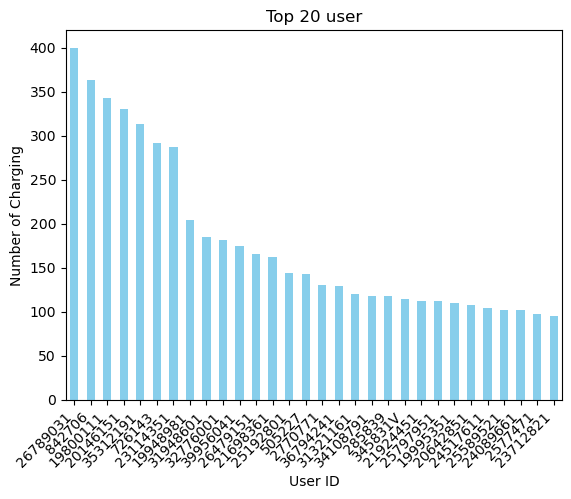

In [82]:
top_30_users = value_counts_User_name.sort_values(ascending=False).head(30)

figsize=(10, 6)
top_30_users.plot(kind='bar', color='skyblue')
plt.title('Top 20 user')
plt.xlabel('User ID')
plt.ylabel('Number of Charging')
plt.xticks(rotation=45, ha='right')

In [83]:
unique_vehicles_per_station = df.groupby('Station Name')['User ID'].nunique()
print (unique_vehicles_per_station)

Station Name
7SPC / BR - JC LIBRARY         2
7SPC / BR-JC LIBRARY          68
7SPC / BR-JONESBOROUGH        25
7SPC / CFEC SPENCER           42
7SPC / COLUMBUS L&W           19
                            ... 
UT PARKING / S7 STATION 1    183
WCMES / CITYHALL1-L           63
WCMES / CITYHALL2-R           77
WRECC / STATION 1            163
WRECC / STATION 2            302
Name: User ID, Length: 153, dtype: int64


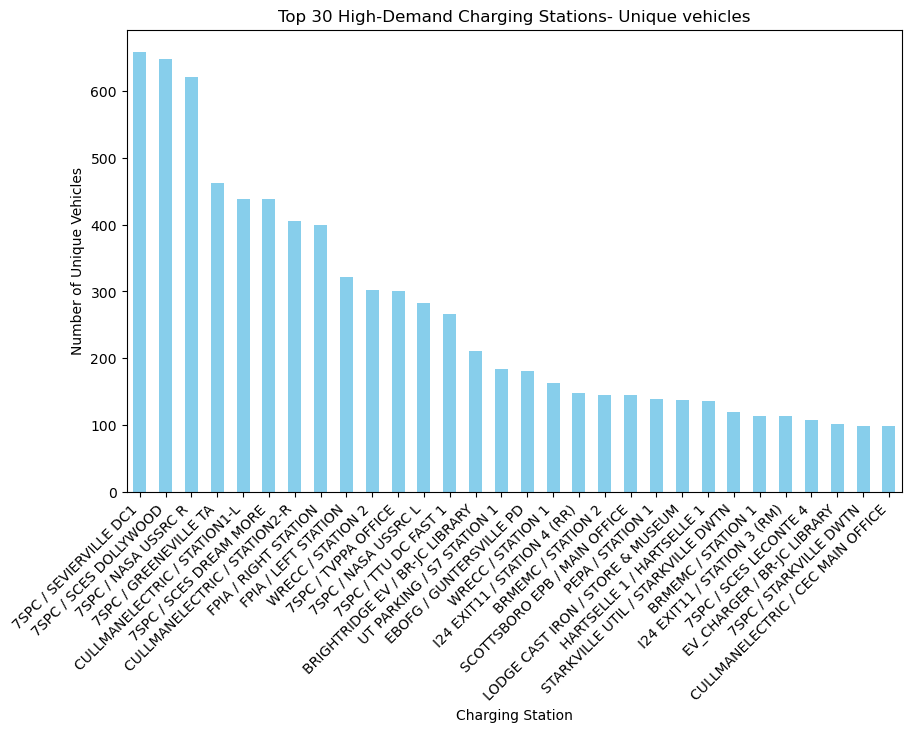

In [84]:
# Assuming 'unique_vehicles_per_station' is the Series you obtained
top_30_stations = unique_vehicles_per_station.sort_values(ascending=False).head(30)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations- Unique vehicles')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()


# Unique vehicle DC

In [85]:
value_counts_station_name_DC= df_DC["Station Name"].value_counts()
unique_values_column_station_name_DC = df_DC['Station Name'].unique()


print(value_counts_station_name_DC)

Station Name
7SPC / SEVIERVILLE DC1             2164
FPIA / RIGHT STATION               1323
FPIA / LEFT STATION                1228
7SPC / GREENEVILLE TA              1226
CULLMANELECTRIC / STATION1-L       1212
WRECC / STATION 2                   978
CULLMANELECTRIC / STATION2-R        964
7SPC / TTU DC FAST 1                780
WRECC / STATION 1                   433
I24 EXIT11 / STATION 4 (RR)         431
BRMEMC / STATION 2                  413
WCMES / CITYHALL2-R                 342
BRMEMC / STATION 1                  278
PEPA / STATION 1                    273
I24 EXIT11 / STATION 3 (RM)         269
WCMES / CITYHALL1-L                 252
BTES / STATION 3 (RM)               178
PEPA / STATION 2                    178
JEFFERSON AVE. / OXFORD STA1(L)     171
LAWRENCEBURG / STATION 2 (R)        170
I24 EXIT11 / STATION 2 (LM)         163
JEFFERSON AVE. / OXFORD STA2(R)     162
BTES / STATION 4 (RR)               145
LAWRENCEBURG / STATION 1 (L)        142
AEC / STATION #1 (L)       

In [86]:
value_counts_User_name_DC= df_DC["User ID"].value_counts()
print(value_counts_User_name_DC)

User ID
35312191    312
23114351    287
24517611    104
25743461     88
33545831     71
           ... 
28003291      1
21229891      1
36592261      1
37894311      1
25837511      1
Name: count, Length: 4051, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '35312191'),
  Text(1, 0, '23114351'),
  Text(2, 0, '24517611'),
  Text(3, 0, '25743461'),
  Text(4, 0, '33545831'),
  Text(5, 0, '32394181'),
  Text(6, 0, '33864851'),
  Text(7, 0, '28519711'),
  Text(8, 0, '30374211'),
  Text(9, 0, '36564161'),
  Text(10, 0, '32565201'),
  Text(11, 0, '25211751'),
  Text(12, 0, '32571961'),
  Text(13, 0, '20722781'),
  Text(14, 0, '35926581'),
  Text(15, 0, '35255021'),
  Text(16, 0, '25589521'),
  Text(17, 0, '631985'),
  Text(18, 0, '22460041'),
  Text(19, 0, '42971291'),
  Text(20, 0, '27256711'),
  Text(21, 0, '30385091'),
  Text(22, 0, '598917'),
  Text(23, 0, '40433041'),
  Text(24, 0, '37376481'),
  Text(25, 0, '37970521'),
  Text(26, 0, '42356801'),
  Text(27, 0, '31261131'),
  Text(28, 0, '22632801'),
  Text(29, 0, '28188521')])

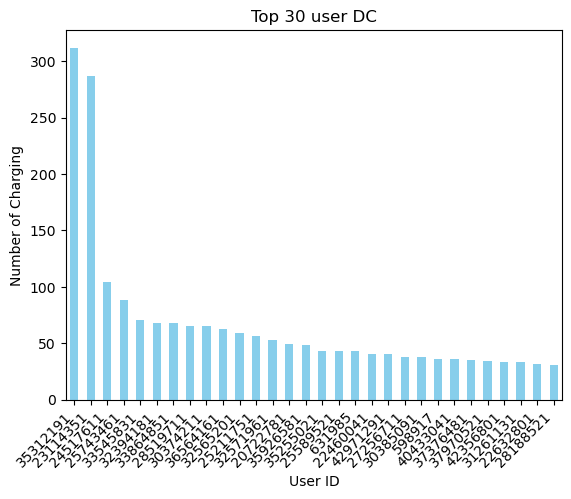

In [87]:
top_30_users_DC = value_counts_User_name_DC.sort_values(ascending=False).head(30)

figsize=(10, 6)
top_30_users_DC.plot(kind='bar', color='skyblue')
plt.title('Top 30 user DC')
plt.xlabel('User ID')
plt.ylabel('Number of Charging')
plt.xticks(rotation=45, ha='right')

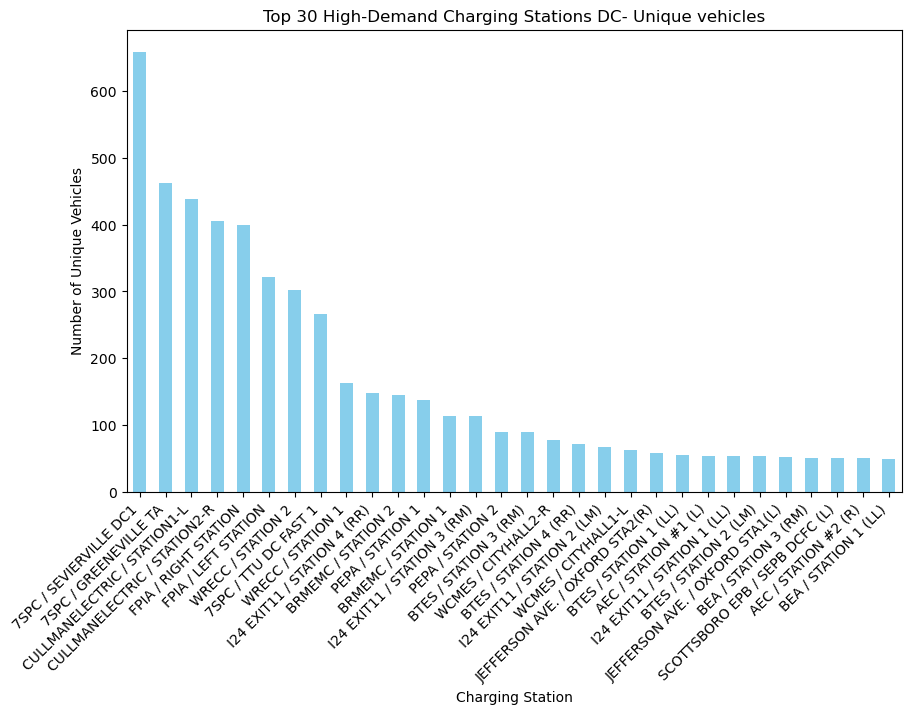

In [88]:
unique_vehicles_per_station_DC = df_DC.groupby('Station Name')['User ID'].nunique()
#print (unique_vehicles_per_station)

top_30_stations_DC = unique_vehicles_per_station_DC.sort_values(ascending=False).head(30)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations_DC.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations DC- Unique vehicles')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

# Total Energy Utilization for Each Month

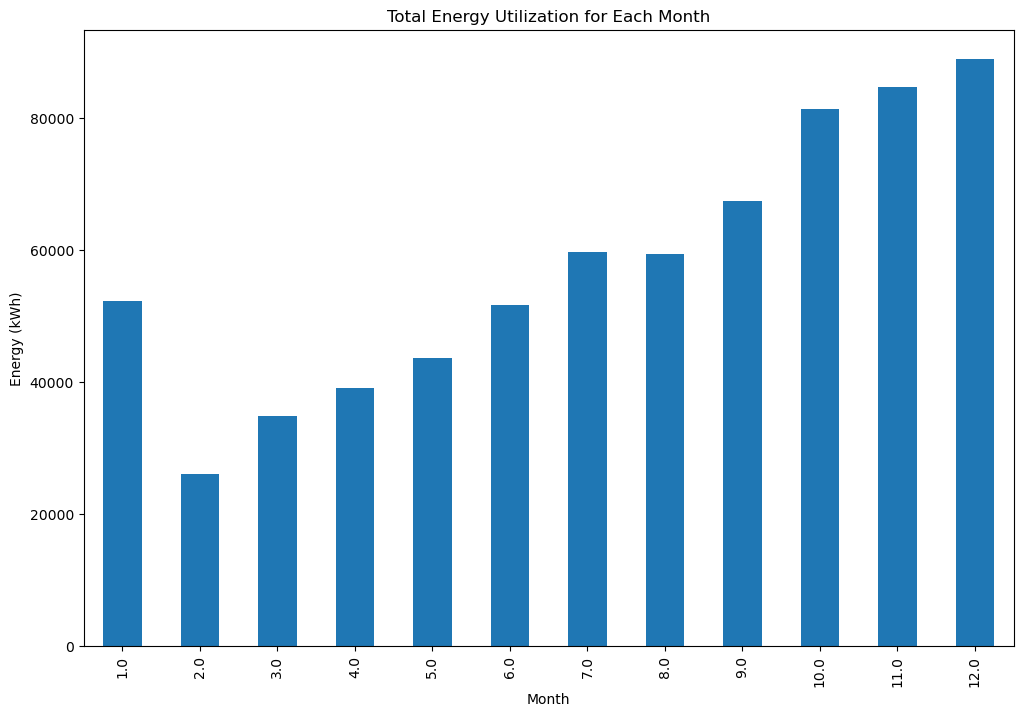

In [113]:
# Group by month and sum the energy
grouped = df.groupby(df['Start_Tim_EST'].dt.month)['Energy (kWh)'].sum()

# Plot the data
grouped.plot(kind='bar', figsize=(12, 8))
plt.title('Total Energy Utilization for Each Month')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.show()

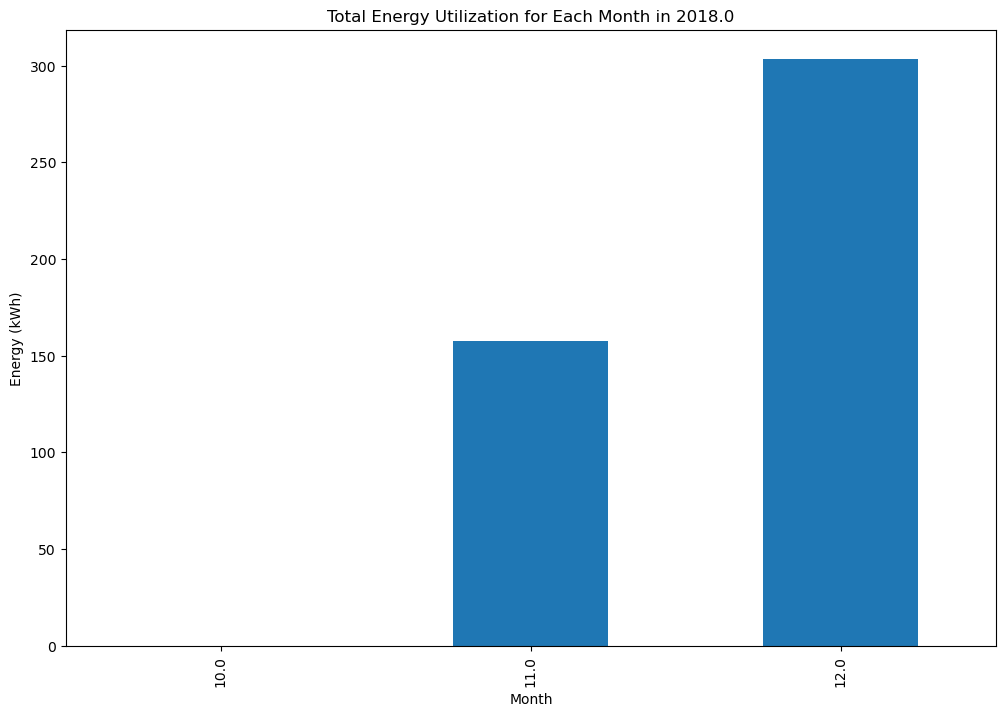

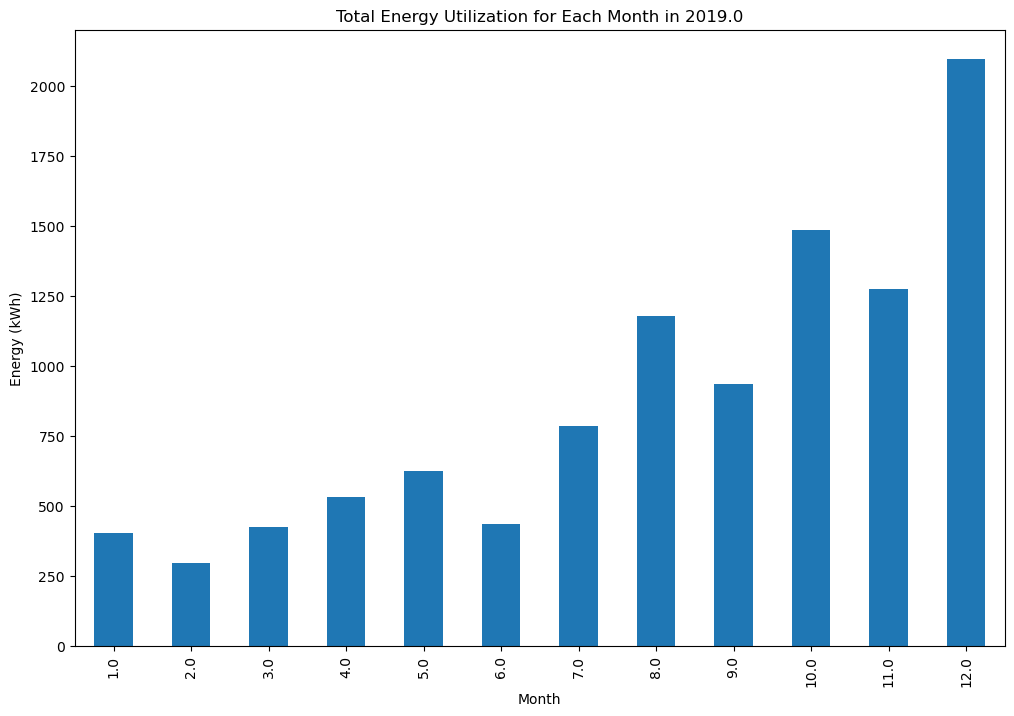

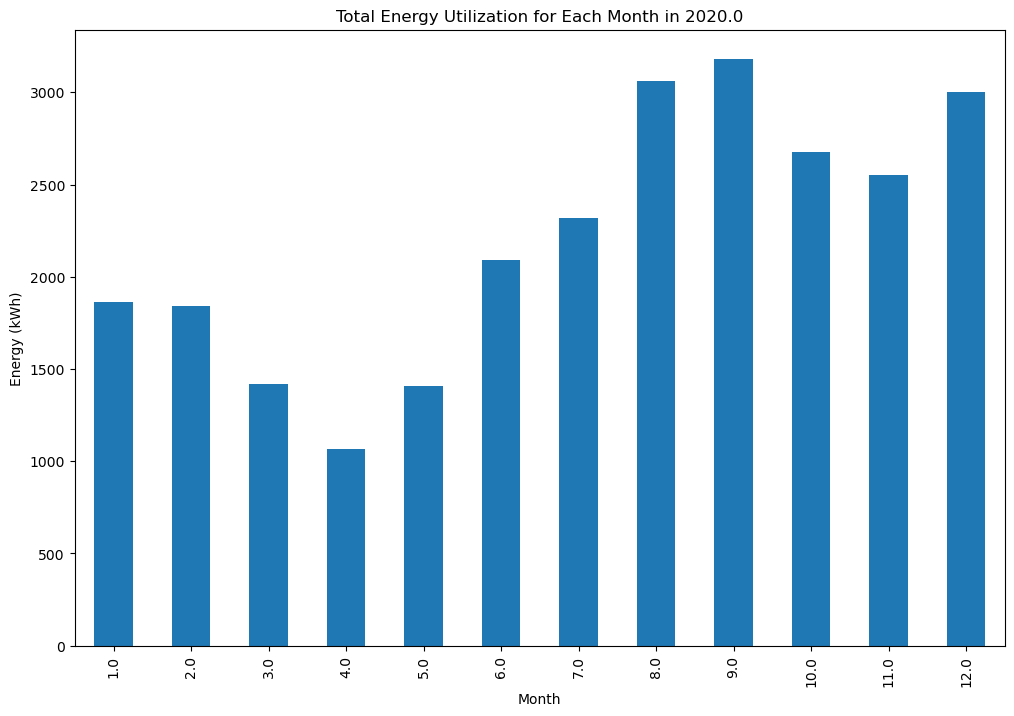

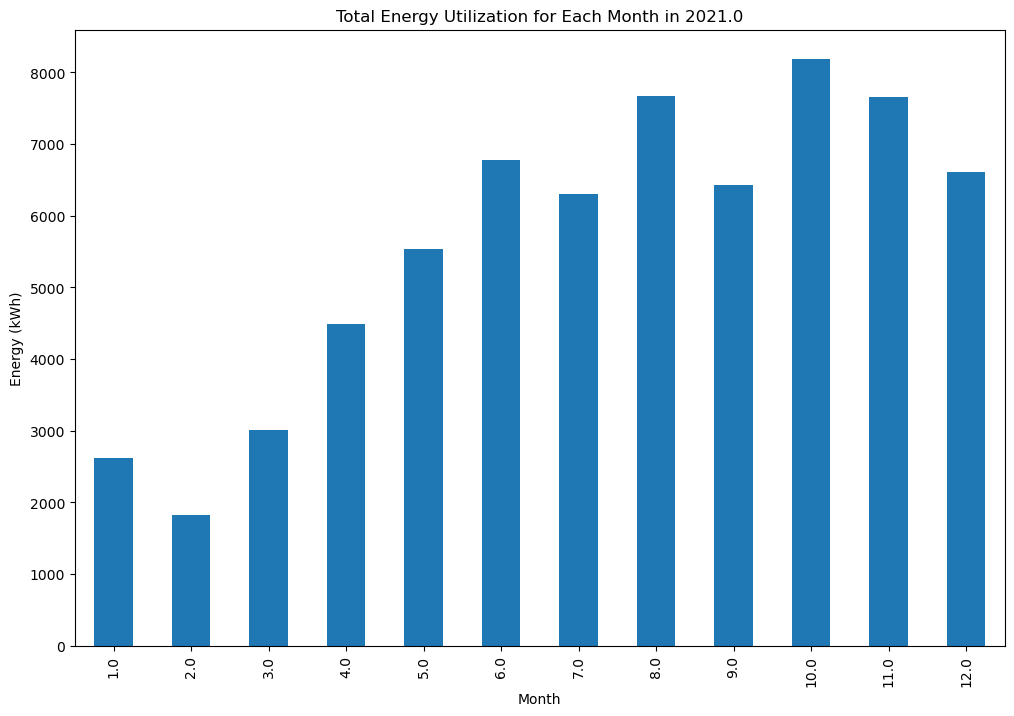

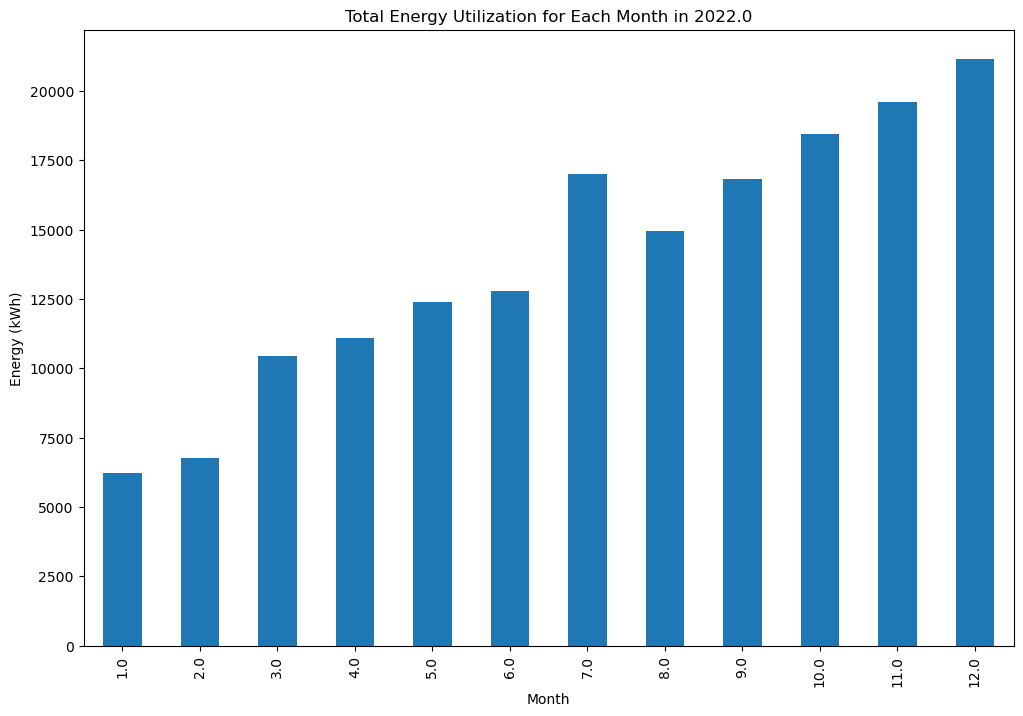

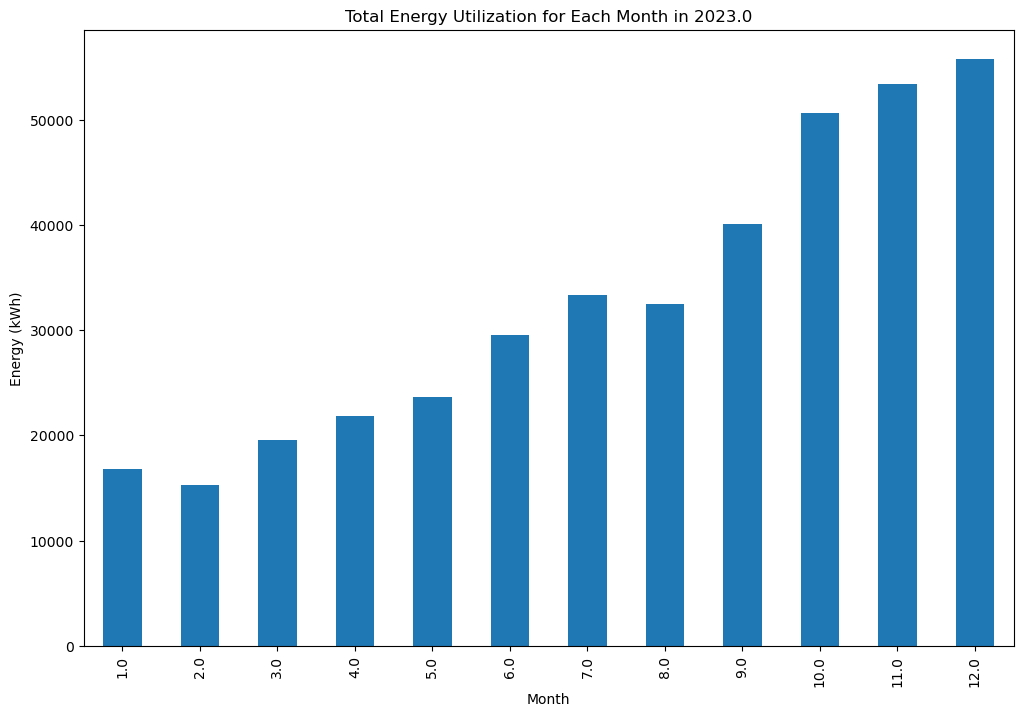

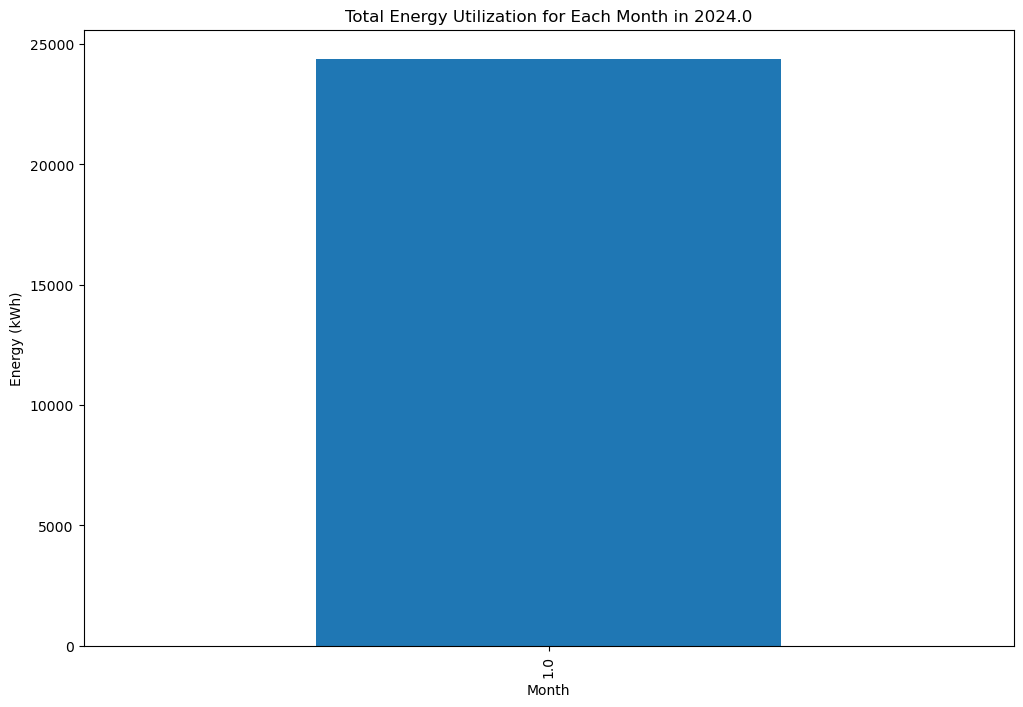

KeyError: nan

In [114]:
# Group by year and month, then sum the energy
grouped = df.groupby([df['Start_Tim_EST'].dt.year, df['Start_Tim_EST'].dt.month])['Energy (kWh)'].sum()

# Get the unique years in your data
years = df['Start_Tim_EST'].dt.year.unique()

# Create a separate bar chart for each year
for year in years:
    data = grouped[year]
    data.plot(kind='bar', figsize=(12, 8))
    plt.title(f'Total Energy Utilization for Each Month in {year}')
    plt.xlabel('Month')
    plt.ylabel('Energy (kWh)')
    plt.show()

# L2

In [89]:
value_counts_station_name_L2= df_L2["Station Name"].value_counts()
unique_values_column_station_name_L2 = df_L2['Station Name'].unique()
value_counts_User_name_L2= df_L2["User ID"].value_counts()


#print(value_counts_station_name_L2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '26789031'),
  Text(1, 0, '842706'),
  Text(2, 0, '19800111'),
  Text(3, 0, '20146151'),
  Text(4, 0, '726143'),
  Text(5, 0, '19948981'),
  Text(6, 0, '31948601'),
  Text(7, 0, '39956041'),
  Text(8, 0, '32776001'),
  Text(9, 0, '26479151'),
  Text(10, 0, '21698361'),
  Text(11, 0, '25192801'),
  Text(12, 0, '505227'),
  Text(13, 0, '36794241'),
  Text(14, 0, '31321161'),
  Text(15, 0, '2770771'),
  Text(16, 0, '34108791'),
  Text(17, 0, '345831V'),
  Text(18, 0, '285839'),
  Text(19, 0, '25797951'),
  Text(20, 0, '21924451'),
  Text(21, 0, '19995351'),
  Text(22, 0, '20642851'),
  Text(23, 0, '24089661'),
  Text(24, 0, '2577471'),
  Text(25, 0, '23712821'),
  Text(26, 0, '22457141'),
  Text(27, 0, '33732041'),
  Text(28, 0, '27405401'),
  Text(29, 0, '28493451')])

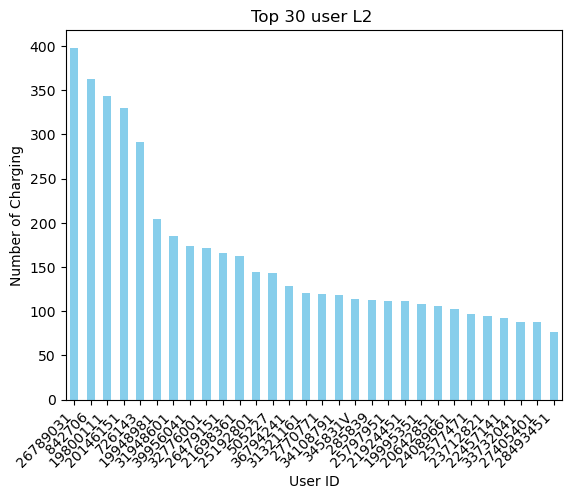

In [90]:
top_30_users_L2 = value_counts_User_name_L2.sort_values(ascending=False).head(30)

figsize=(10, 6)
top_30_users_L2.plot(kind='bar', color='skyblue')
plt.title('Top 30 user L2 ')
plt.xlabel('User ID')
plt.ylabel('Number of Charging')
plt.xticks(rotation=45, ha='right')

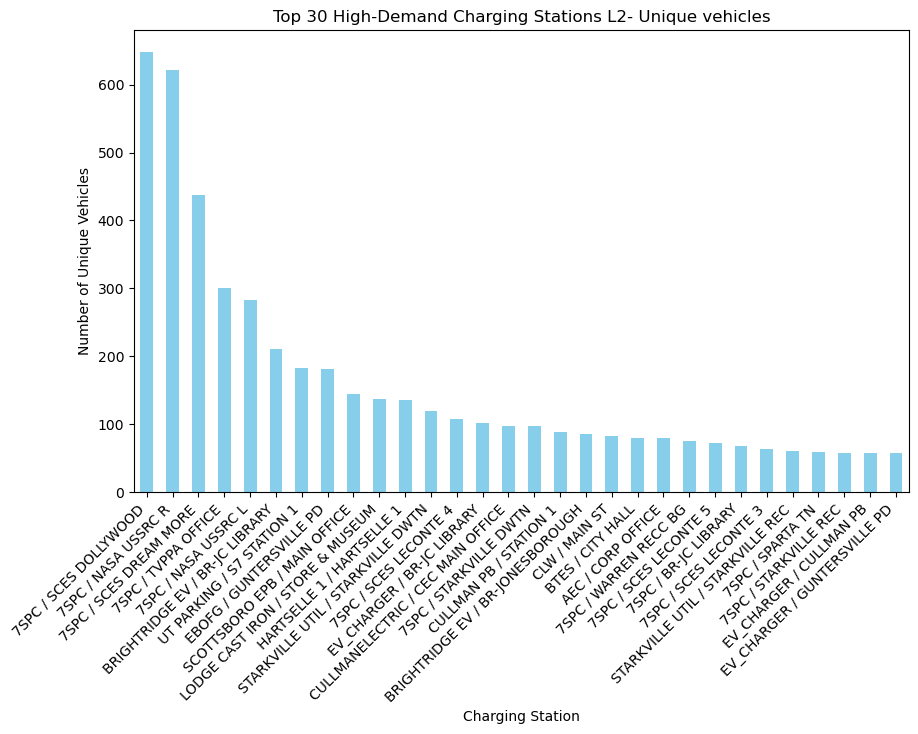

In [91]:
unique_vehicles_per_station_L2 = df_L2.groupby('Station Name')['User ID'].nunique()
#print (unique_vehicles_per_station)

top_30_stations_L2 = unique_vehicles_per_station_L2.sort_values(ascending=False).head(30)

# Plotting
plt.figure(figsize=(10, 6))
top_30_stations_L2.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations L2- Unique vehicles')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

# Perform a utilization analysis over time

Utilization analysis: Look at usage rates over time for each station - how often is it occupied, peak usage times, etc. This can help guide pricing, load balancing, and future expansion plans​.

In [92]:
df['Start_Tim_EST'] = pd.to_datetime(df['Start_Tim_EST'])
df = df.sort_values('Start_Tim_EST')

# Group by year and count
df_grouped = df.groupby(df['Start_Tim_EST'].dt.year).size()

print(df_grouped)

Start_Tim_EST
2018.0       62
2019.0     1029
2020.0     1884
2021.0     4708
2022.0     9606
2023.0    18598
2024.0     1053
dtype: int64


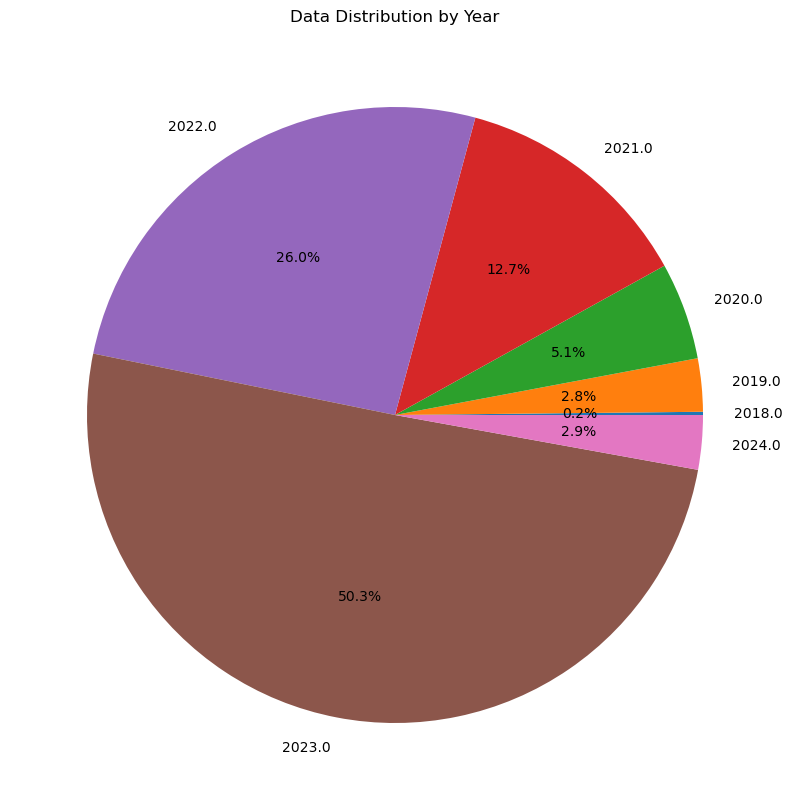

In [112]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the pie chart
df_grouped.plot(kind='pie', autopct='%1.1f%%', ax=ax)

ax.set_title('Data Distribution by Year')
ax.set_ylabel('')  # This is to remove the default label that comes with the pie chart
plt.show()

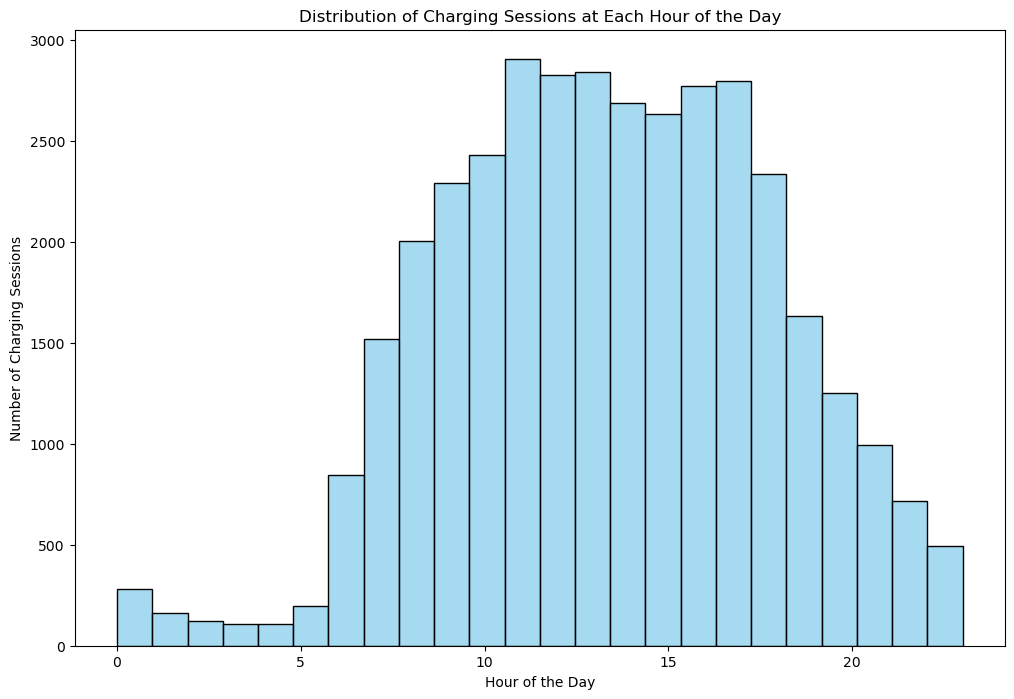

In [94]:
df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Hour'] = df['Start_Tim_EST'].dt.hour

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Hour', bins=24, kde=False, color='skyblue')
plt.title('Distribution of Charging Sessions at Each Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Charging Sessions')
plt.show()

In [95]:
df['Month'] = df['Start_Tim_EST'].dt.month

# Grouping by Station Name and Month
utilization_by_month = df.groupby(['Station Name', 'Month']).size().reset_index(name='Charging Count')

TypeError: can only concatenate list (not "int") to list

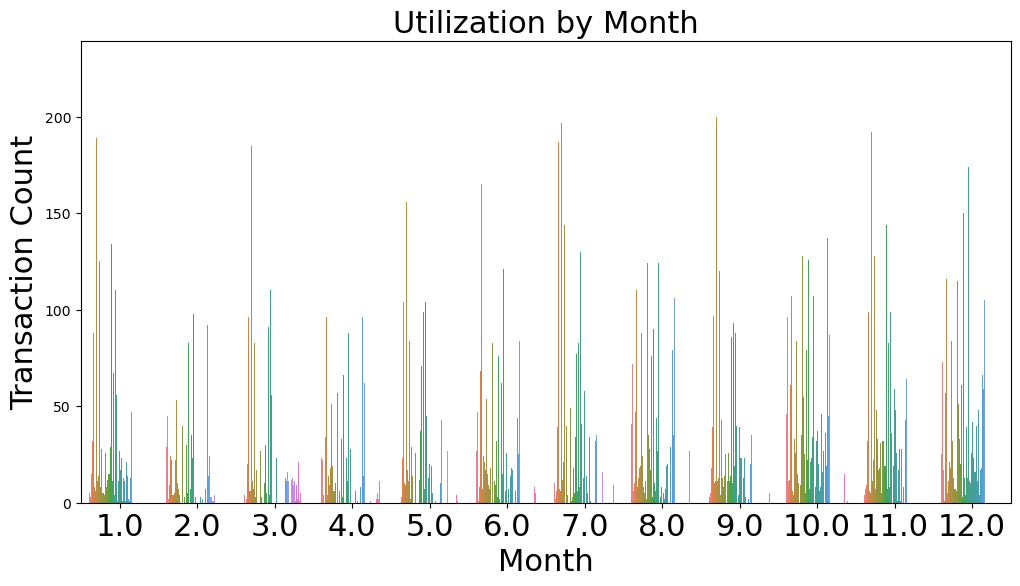

In [96]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Month', y='Charging Count', hue='Station Name', data=utilization_by_month)
plt.title('Utilization by Month', fontsize=22)  

ax.set_xlabel('Month', fontsize=22)
ax.set_ylabel('Transaction Count', fontsize=22)
ax.tick_params(axis='x', labelsize=22)
plt.legend().set_visible(False)
ax.set_xticklabels(ax.get_xticks() + 1)

plt.show()


In [ ]:
---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[60], line 11
      9 # Create a separate bar chart for each year
     10 for year in years:
---> 11     data = grouped[year]
     12     data.plot(kind='bar', figsize=(12, 8))
     13     plt.title(f'Distribution of Charging Sessions for Each Month in {year}')

File ~\anaconda3\envs\cuip\Lib\site-packages\pandas\core\series.py:1040, in Series.__getitem__(self, key)
   1037     return self._values[key]
   1039 elif key_is_scalar:
-> 1040     return self._get_value(key)
   1042 # Convert generator to list before going through hashable part
   1043 # (We will iterate through the generator there to check for slices)
   1044 if is_iterator(key):

File ~\anaconda3\envs\cuip\Lib\site-packages\pandas\core\series.py:1156, in Series._get_value(self, label, takeable)
   1153     return self._values[label]
   1155 # Similar to Index.get_value, but we do not fall back to positional
-> 1156 loc = self.index.get_loc(label)
   1158 if is_integer(loc):
   1159     return self._values[loc]

File ~\anaconda3\envs\cuip\Lib\site-packages\pandas\core\indexes\multi.py:2925, in MultiIndex.get_loc(self, key)
   2922     return mask
   2924 if not isinstance(key, tuple):
-> 2925     loc = self._get_level_indexer(key, level=0)
   2926     return _maybe_to_slice(loc)
   2928 keylen = len(key)

File ~\anaconda3\envs\cuip\Lib\site-packages\pandas\core\indexes\multi.py:3303, in MultiIndex._get_level_indexer(self, key, level, indexer)
   3299     end = algos.searchsorted(level_codes, idx, side="right")
   3301 if start == end:
   3302     # The label is present in self.levels[level] but unused:
-> 3303     raise KeyError(key)
   3304 return slice(start, end)

KeyError: nan

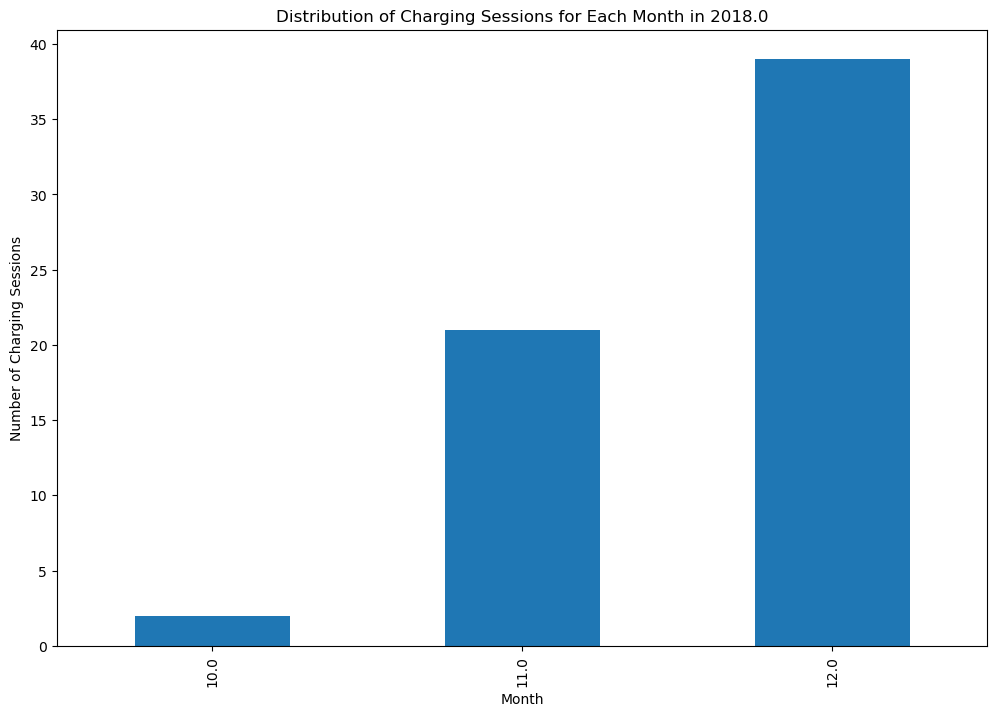

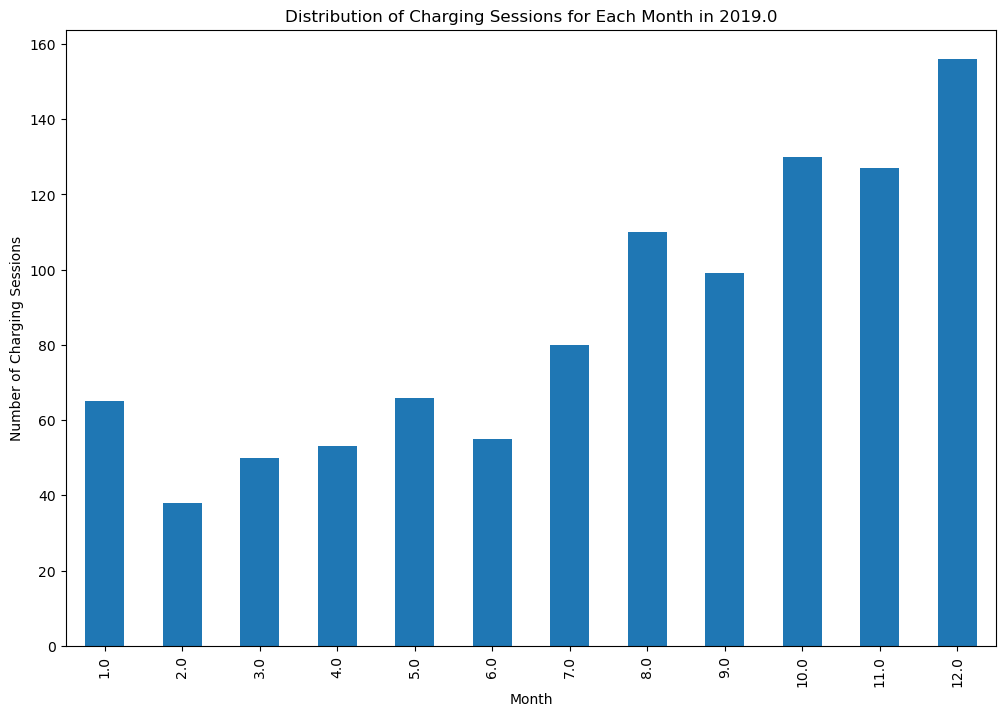

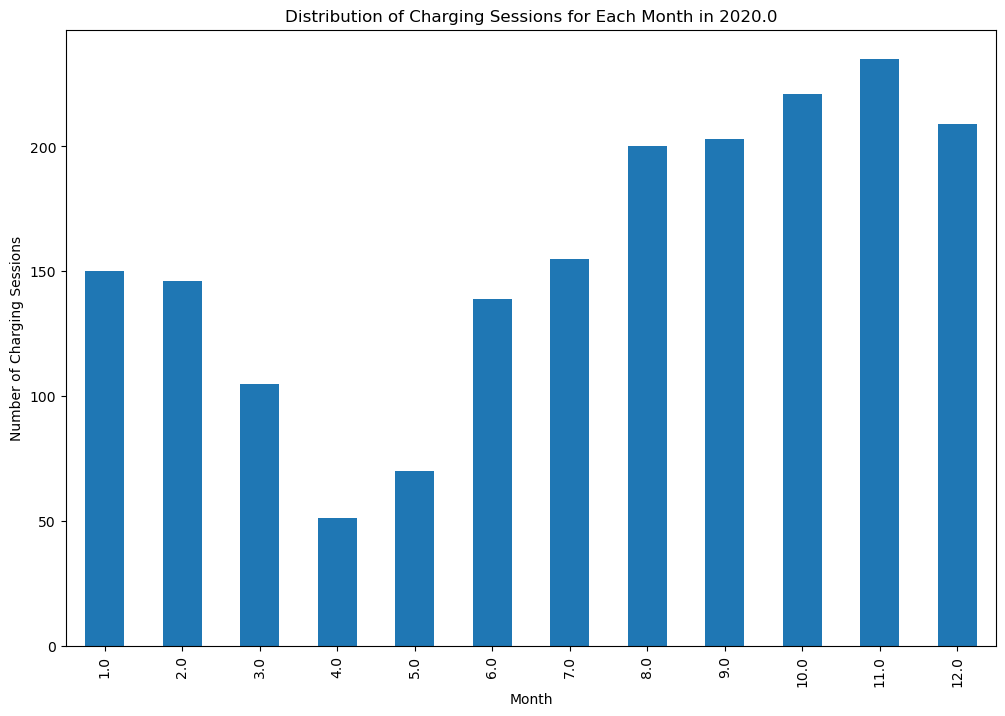

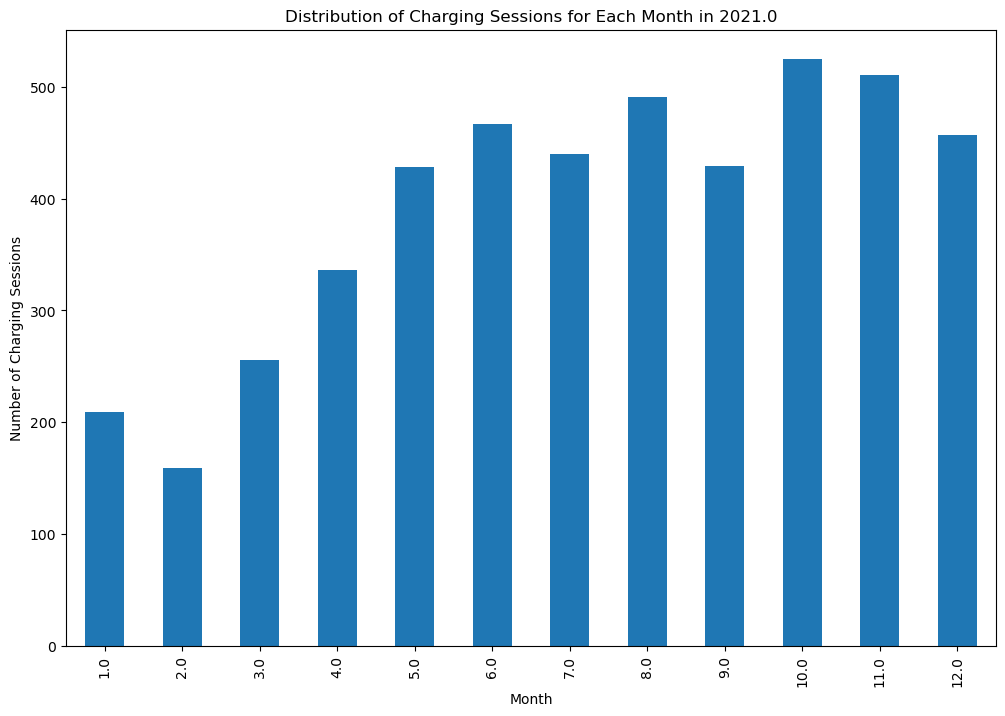

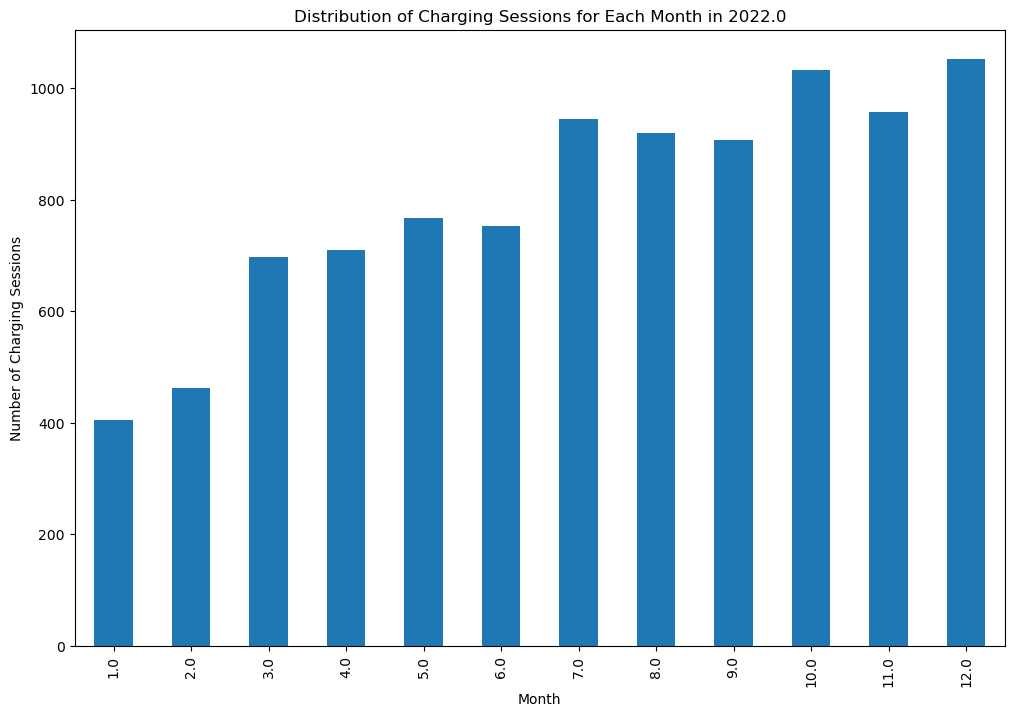

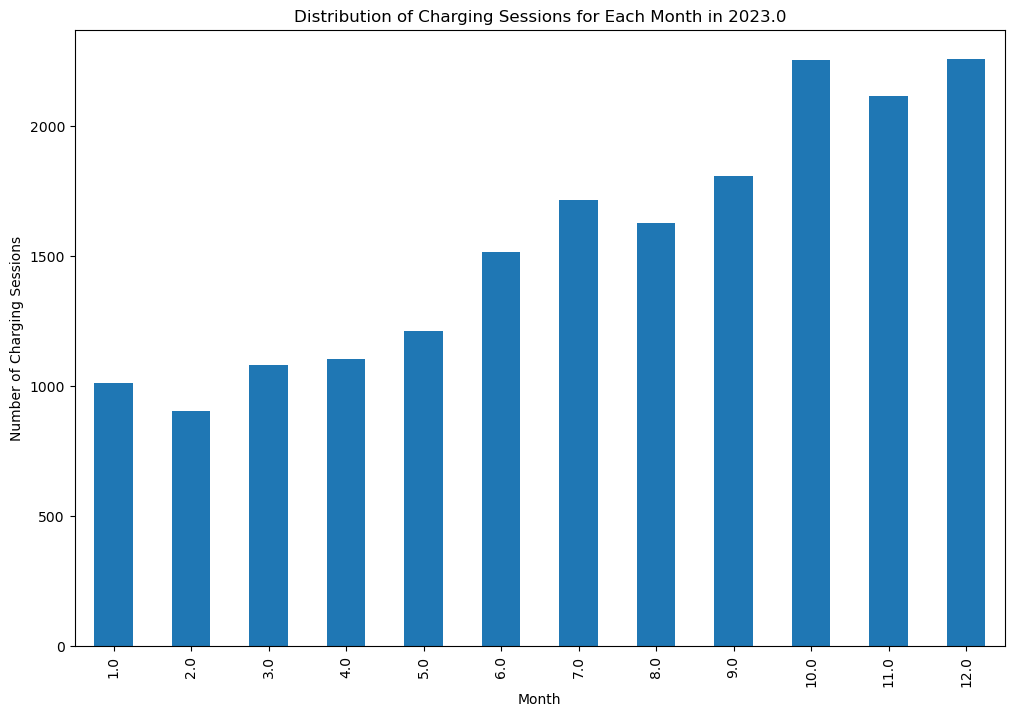

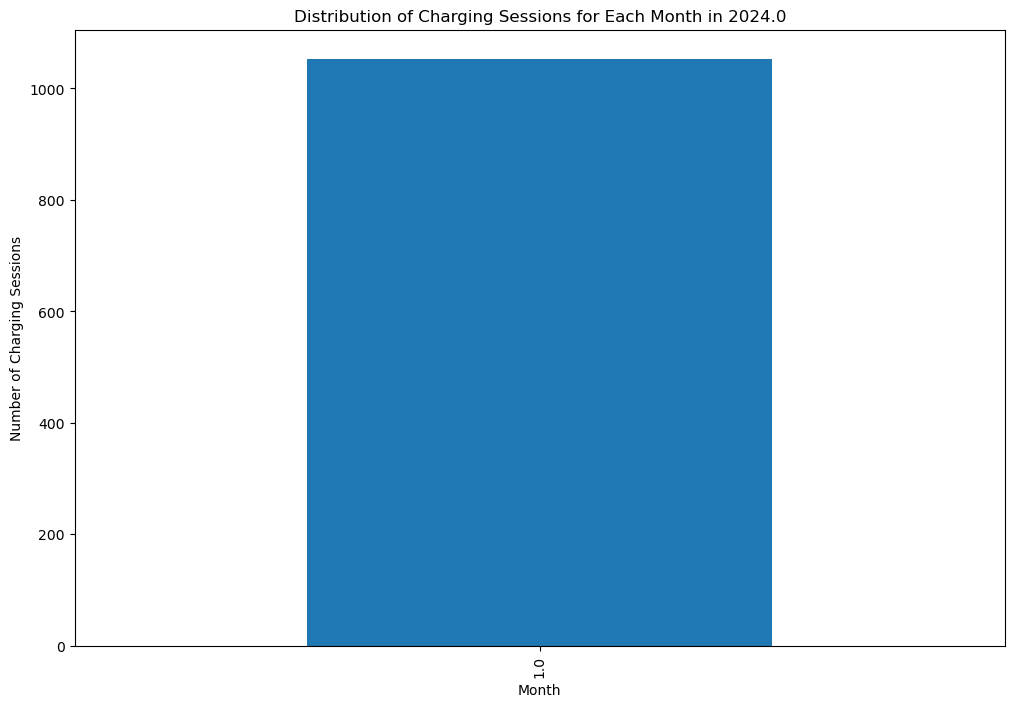

KeyError: nan

In [97]:
df['Year'] = df['Start_Tim_EST'].dt.year
df['Month'] = df['Start_Tim_EST'].dt.month

grouped = df.groupby(['Year', 'Month']).size()

# Get the unique years 
years = df['Year'].unique()


for year in years:
    data = grouped[year]
    data.plot(kind='bar', figsize=(12, 8))
    plt.title(f'Distribution of Charging Sessions for Each Month in {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Charging Sessions')
    plt.show()

#  Year 2024, Jan, Frozen time

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\2337576127.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



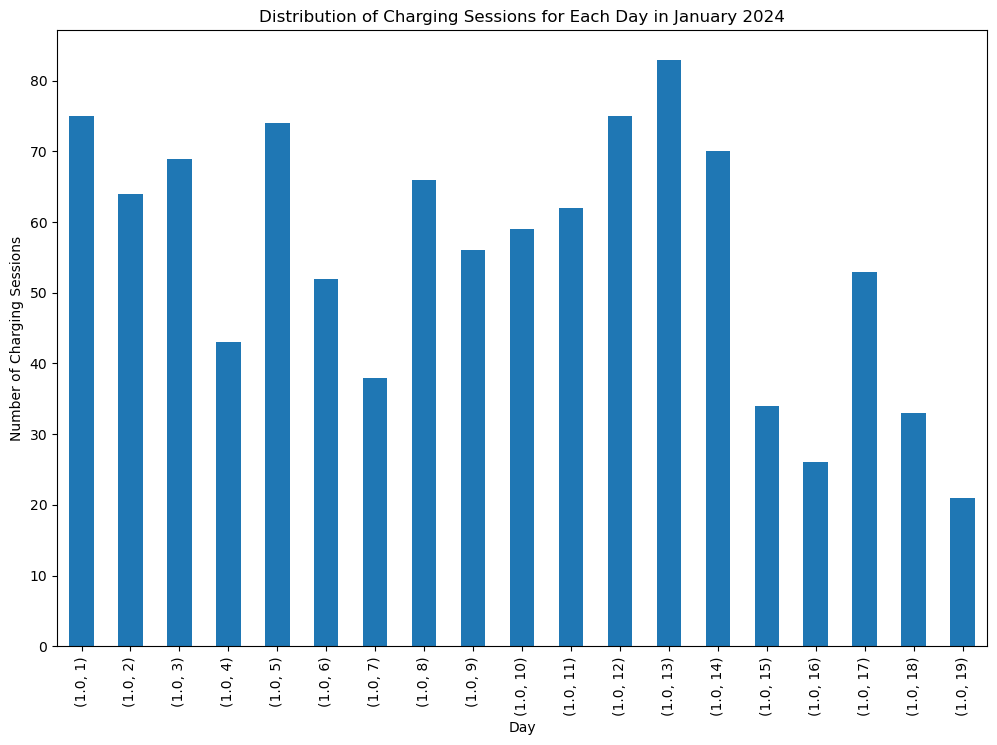

In [98]:
# Filter data for the year 2024
df_2024 = df[df['Year'] == 2024]

# Create a new column for the day
df_2024['Day'] = df_2024['Start_Tim_EST'].dt.day

# Group by day and count
grouped = df_2024.groupby(['Month', 'Day']).size()

# Plot the data
grouped.plot(kind='bar', figsize=(12, 8))
plt.title('Distribution of Charging Sessions for Each Day in January 2024')
plt.xlabel('Day')
plt.ylabel('Number of Charging Sessions')
plt.show()

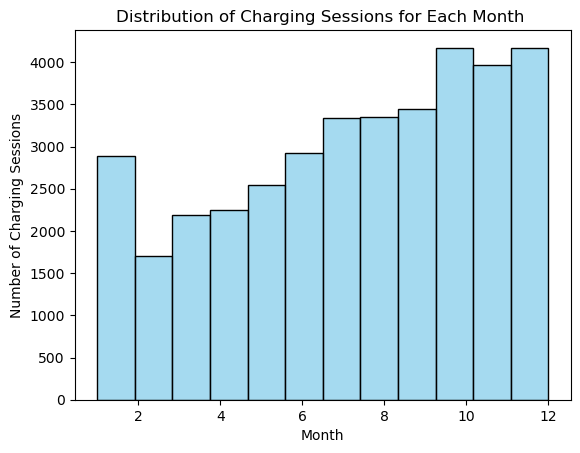

In [99]:
df['Month'] = df['Start_Tim_EST'].dt.month

#plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Month', bins=12, kde=False, color='skyblue')
plt.title('Distribution of Charging Sessions for Each Month ')
plt.xlabel('Month')
plt.ylabel('Number of Charging Sessions')
plt.show()

### L2

In [100]:
df_L2['Transaction Date (Pacific Time)'] = pd.to_datetime(df_L2['Transaction Date (Pacific Time)'])
df_L2['Hour'] = df_L2['Transaction Date (Pacific Time)'].dt.hour
utilization_data_L2 = df_L2.groupby(['Station Name', 'Hour']).size().reset_index(name='Transaction Count')


C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\50374706.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\50374706.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



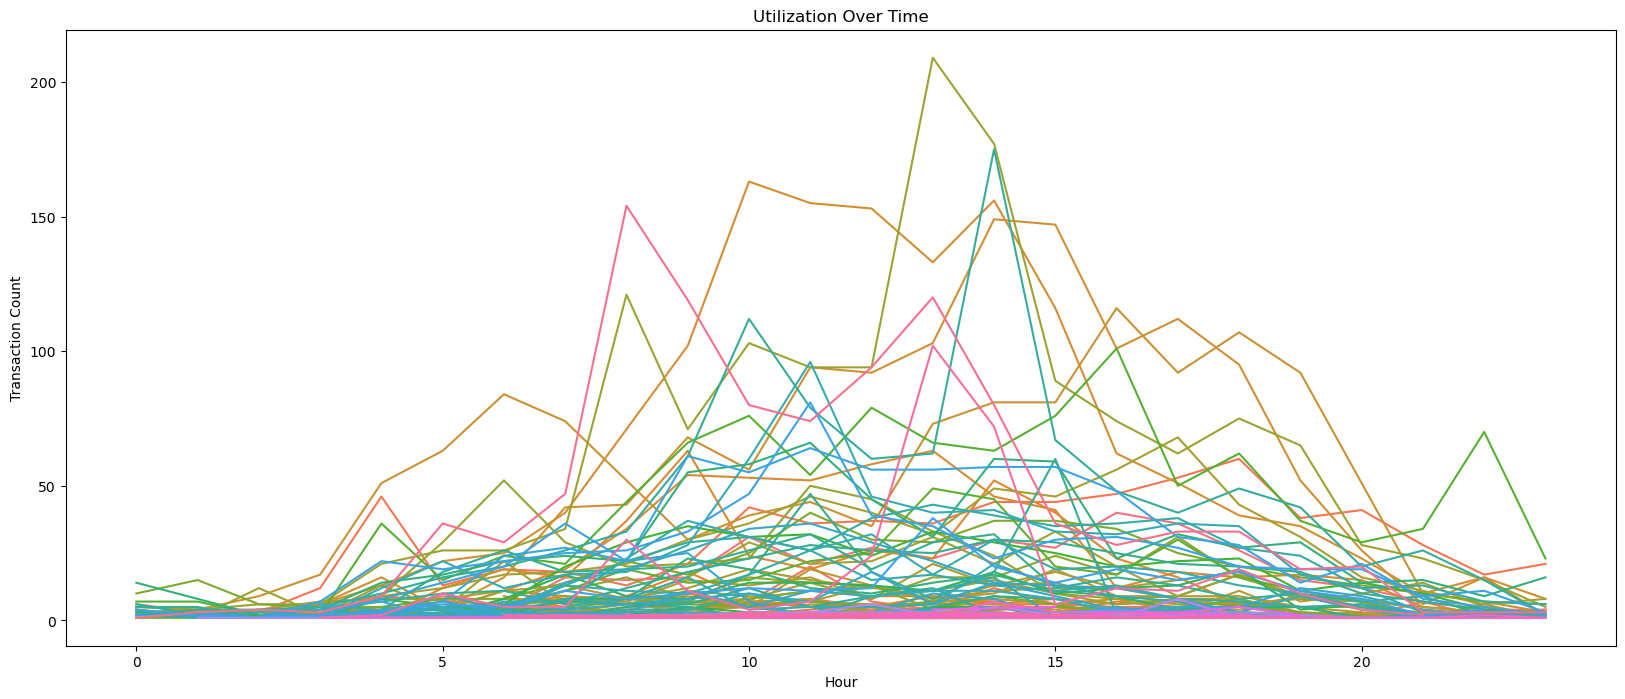

In [102]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='Hour', y='Transaction Count', hue='Station Name', data=utilization_data_L2,legend=False)
plt.title('Utilization Over Time')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
#plt.legend(title='Station Name')
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\2021273969.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



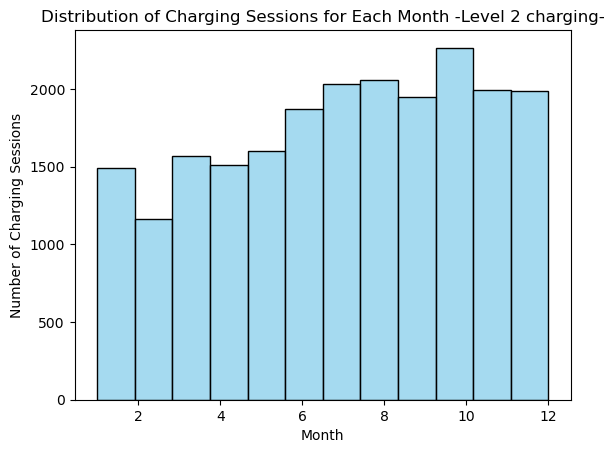

In [104]:
df_L2['Month'] = df_L2['Start_Tim_EST'].dt.month

#plt.figure(figsize=(12, 8))
sns.histplot(data=df_L2, x='Month', bins=12, kde=False, color='skyblue')
plt.title('Distribution of Charging Sessions for Each Month -Level 2 charging-')
plt.xlabel('Month')
plt.ylabel('Number of Charging Sessions')
plt.show()

### DC fast 

In [105]:
df_DC['Transaction Date (Pacific Time)'] = pd.to_datetime(df_DC['Transaction Date (Pacific Time)'])
df_DC['Hour'] = df_DC['Transaction Date (Pacific Time)'].dt.hour
utilization_data_DC = df_DC.groupby(['Station Name', 'Hour']).size().reset_index(name='Transaction Count')

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\2943533406.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\2943533406.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
utilization_data_DC

,Station Name,Hour,Transaction Count
0,7SPC / GREENEVILLE TA,0.0,15
1,7SPC / GREENEVILLE TA,1.0,32
2,7SPC / GREENEVILLE TA,2.0,20
3,7SPC / GREENEVILLE TA,3.0,12
4,7SPC / GREENEVILLE TA,4.0,17
...,...,...,...
894,WRECC / STATION 2,19.0,39
895,WRECC / STATION 2,20.0,24
896,WRECC / STATION 2,21.0,20
897,WRECC / STATION 2,22.0,34


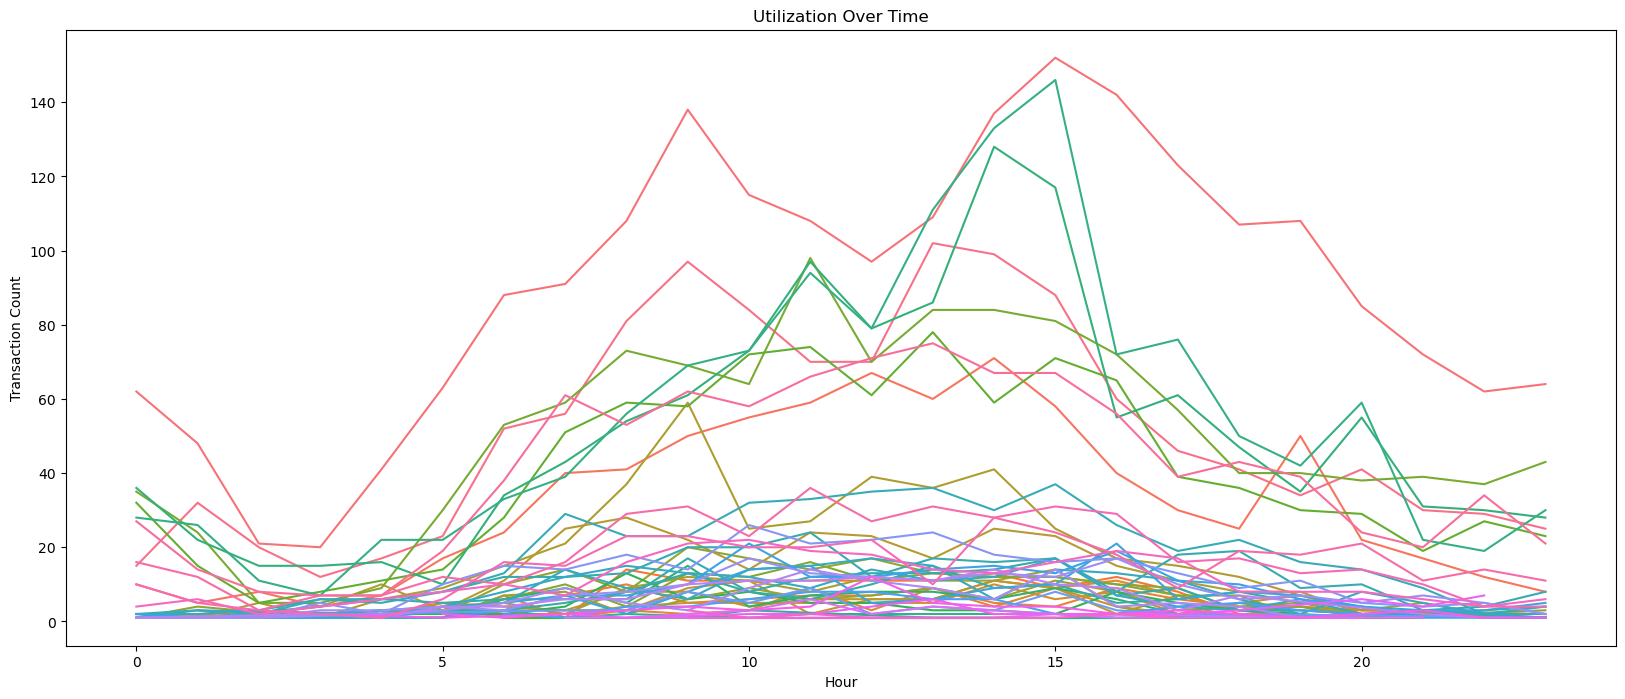

In [107]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='Hour', y='Transaction Count', hue='Station Name', data=utilization_data_DC, legend=False)
plt.title('Utilization Over Time')
plt.xlabel('Hour')
plt.ylabel('Transaction Count')
#plt.legend(title='Station Name')
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_14232\899274224.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



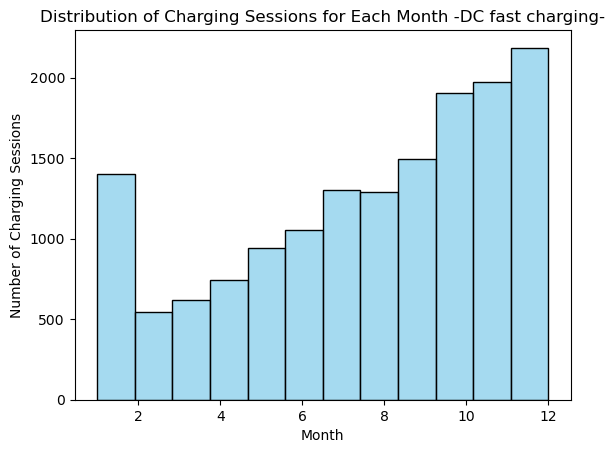

In [109]:
df_DC['Month'] = df_DC['Start_Tim_EST'].dt.month

#plt.figure(figsize=(12, 8))
sns.histplot(data=df_DC, x='Month', bins=12, kde=False, color='skyblue')
plt.title('Distribution of Charging Sessions for Each Month -DC fast charging-')
plt.xlabel('Month')
plt.ylabel('Number of Charging Sessions')
plt.show()

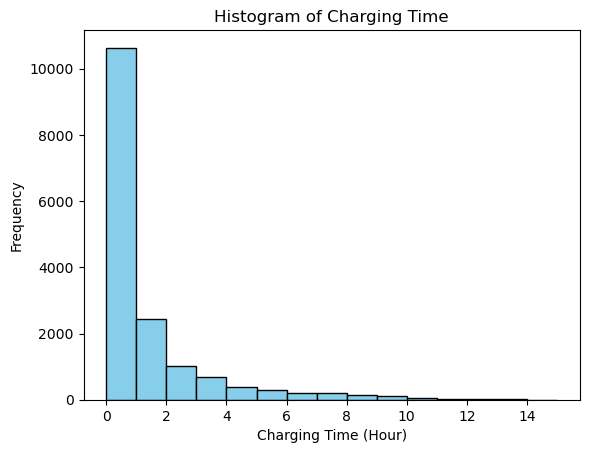

In [75]:

charging_time = df['Charging Time']

# Convert 'Charging Time' to timedelta
charging_time = pd.to_timedelta(charging_time)

# Convert timedelta to hour for easier visualization
charging_time_in_hours = charging_time.dt.total_seconds() / 3600

# Plot histogram
plt.hist(charging_time_in_hours, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], color='skyblue', edgecolor='black')
plt.title('Histogram of Charging Time')
plt.xlabel('Charging Time (Hour)')
plt.ylabel('Frequency')
plt.show()


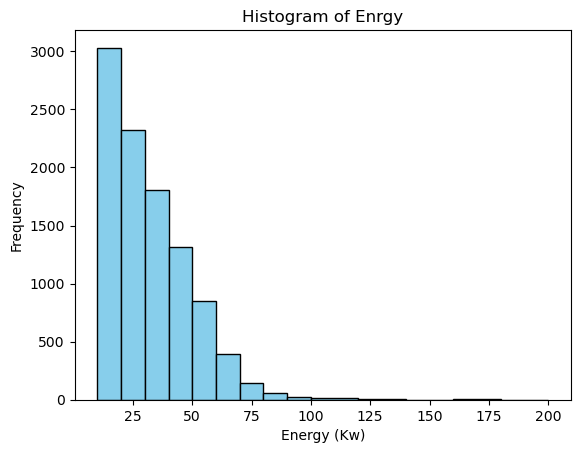

In [77]:
energy_kw = df['Energy (kWh)']
# Plot histogram
plt.hist(energy_kw, bins=[10,20,30,40,50,60,70,80,90,100,120,140,160,180,200], color='skyblue', edgecolor='black')
plt.title('Histogram of Enrgy')
plt.xlabel('Energy (Kw)')
plt.ylabel('Frequency')
plt.show()


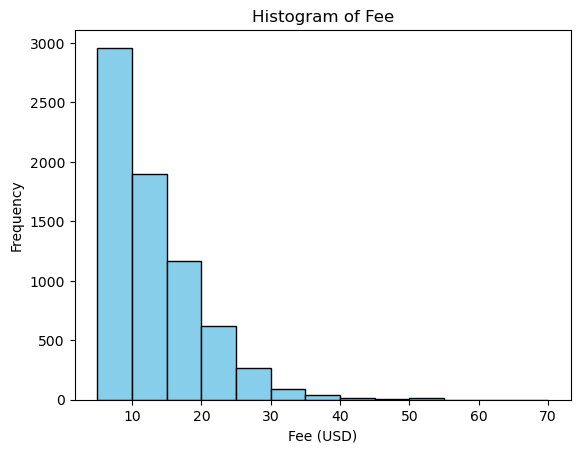

In [93]:
Fee_USD = df['Fee']
# Plot histogram
plt.hist(Fee_USD, bins=[5,10,15,20,25,30,35,40,45,50,55,60,65,70], color='skyblue', edgecolor='black')
plt.title('Histogram of Fee')
plt.xlabel('Fee (USD)')
plt.ylabel('Frequency')
plt.show()


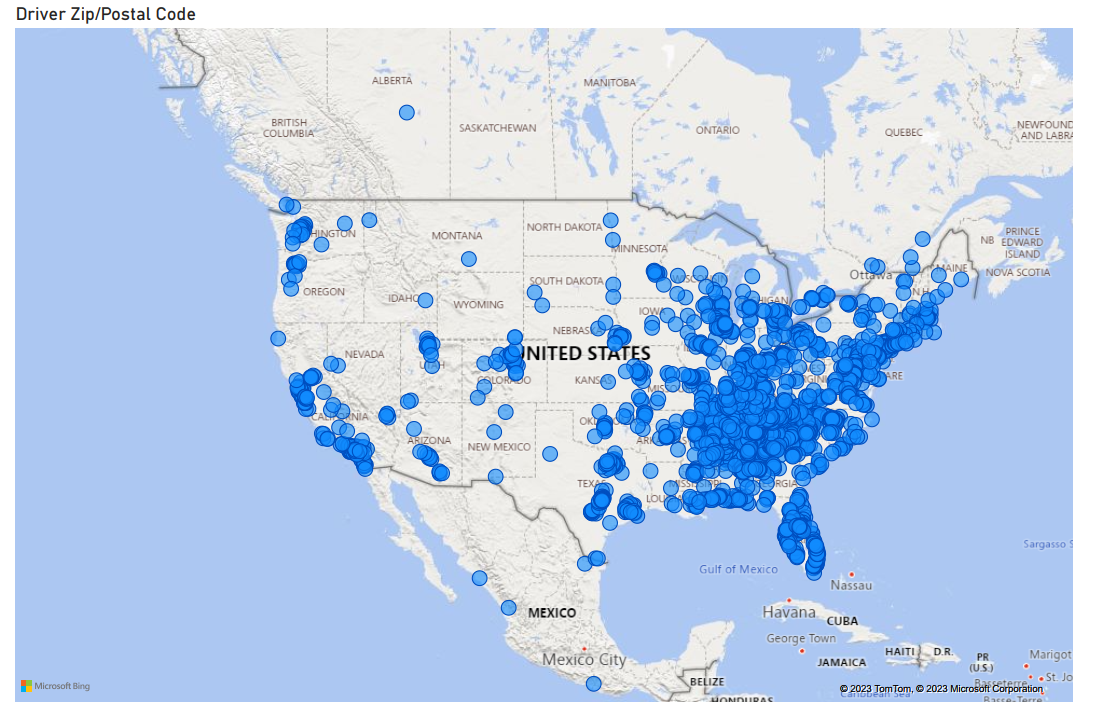


In [98]:
def vectorize_sequence(sequence, dimensions):
    results = np.zeros((len(sequence), dimensions))
    for index,value in enumerate(sequence):
        if max([value]) < dimensions:
            results[index, value] = 1
    return results

sequence = [2, 3, 1, 0]
vectorized_sequence = vectorize_sequence(sequence, 4)
print(vectorized_sequence)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
